# Imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
import prince

In [25]:
# load data
df = pd.read_csv('in-vehicle-coupon-recommendation.csv')

In [26]:
# Show index of duplicates
df_duplicate_analisys = df[df.duplicated(keep=False)]

def remove_dup(df: pd.DataFrame):
    # Now remove duplicates
    df = df.drop_duplicates()
    return df

In [27]:
# Value mapping

def value_mapping(df: pd.DataFrame):
    frequency_map = {'never': 0,'less1': 1,'1~3': 2,'4~8': 3,'gt8': 4}
    age_map = {'below21': 0,'21': 1,'26': 2,'31': 3,'36': 4,'41': 5,'46': 6,'50plus': 7}
    income_map = {'Less than $12500': 0,'$12500 - $24999': 1,'$25000 - $37499': 2,'$37500 - $49999': 3,
    '$50000 - $62499': 4,'$62500 - $74999': 5,'$75000 - $87499': 6,'$87500 - $99999': 7,'$100000 or More': 8}
    temperature_map = {30: 0,55: 1,80: 2}

    # CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, Bar
    df['CoffeeHouse'] = df['CoffeeHouse'].map(frequency_map)
    df['CarryAway'] = df['CarryAway'].map(frequency_map)
    df['RestaurantLessThan20'] = df['RestaurantLessThan20'].map(frequency_map)
    df['Restaurant20To50'] = df['Restaurant20To50'].map(frequency_map)
    df['Bar'] = df['Bar'].map(frequency_map)

    #age
    df['age'] = df['age'].map(age_map)

    #income 
    df['income'] = df['income'].map(income_map)

    #temperature
    df['temperature'] = df['temperature'].map(temperature_map)

    return df

In [28]:
# Drop columns

def drop_columns(df: pd.DataFrame):
    df = df.drop(columns=['car'])
    #df = df.drop(columns=['toCoupon_GEQ5min'])
    df = df.drop(columns=['direction_opp'])
    return df

# Univariate Analysis

In [29]:
data = df.copy()

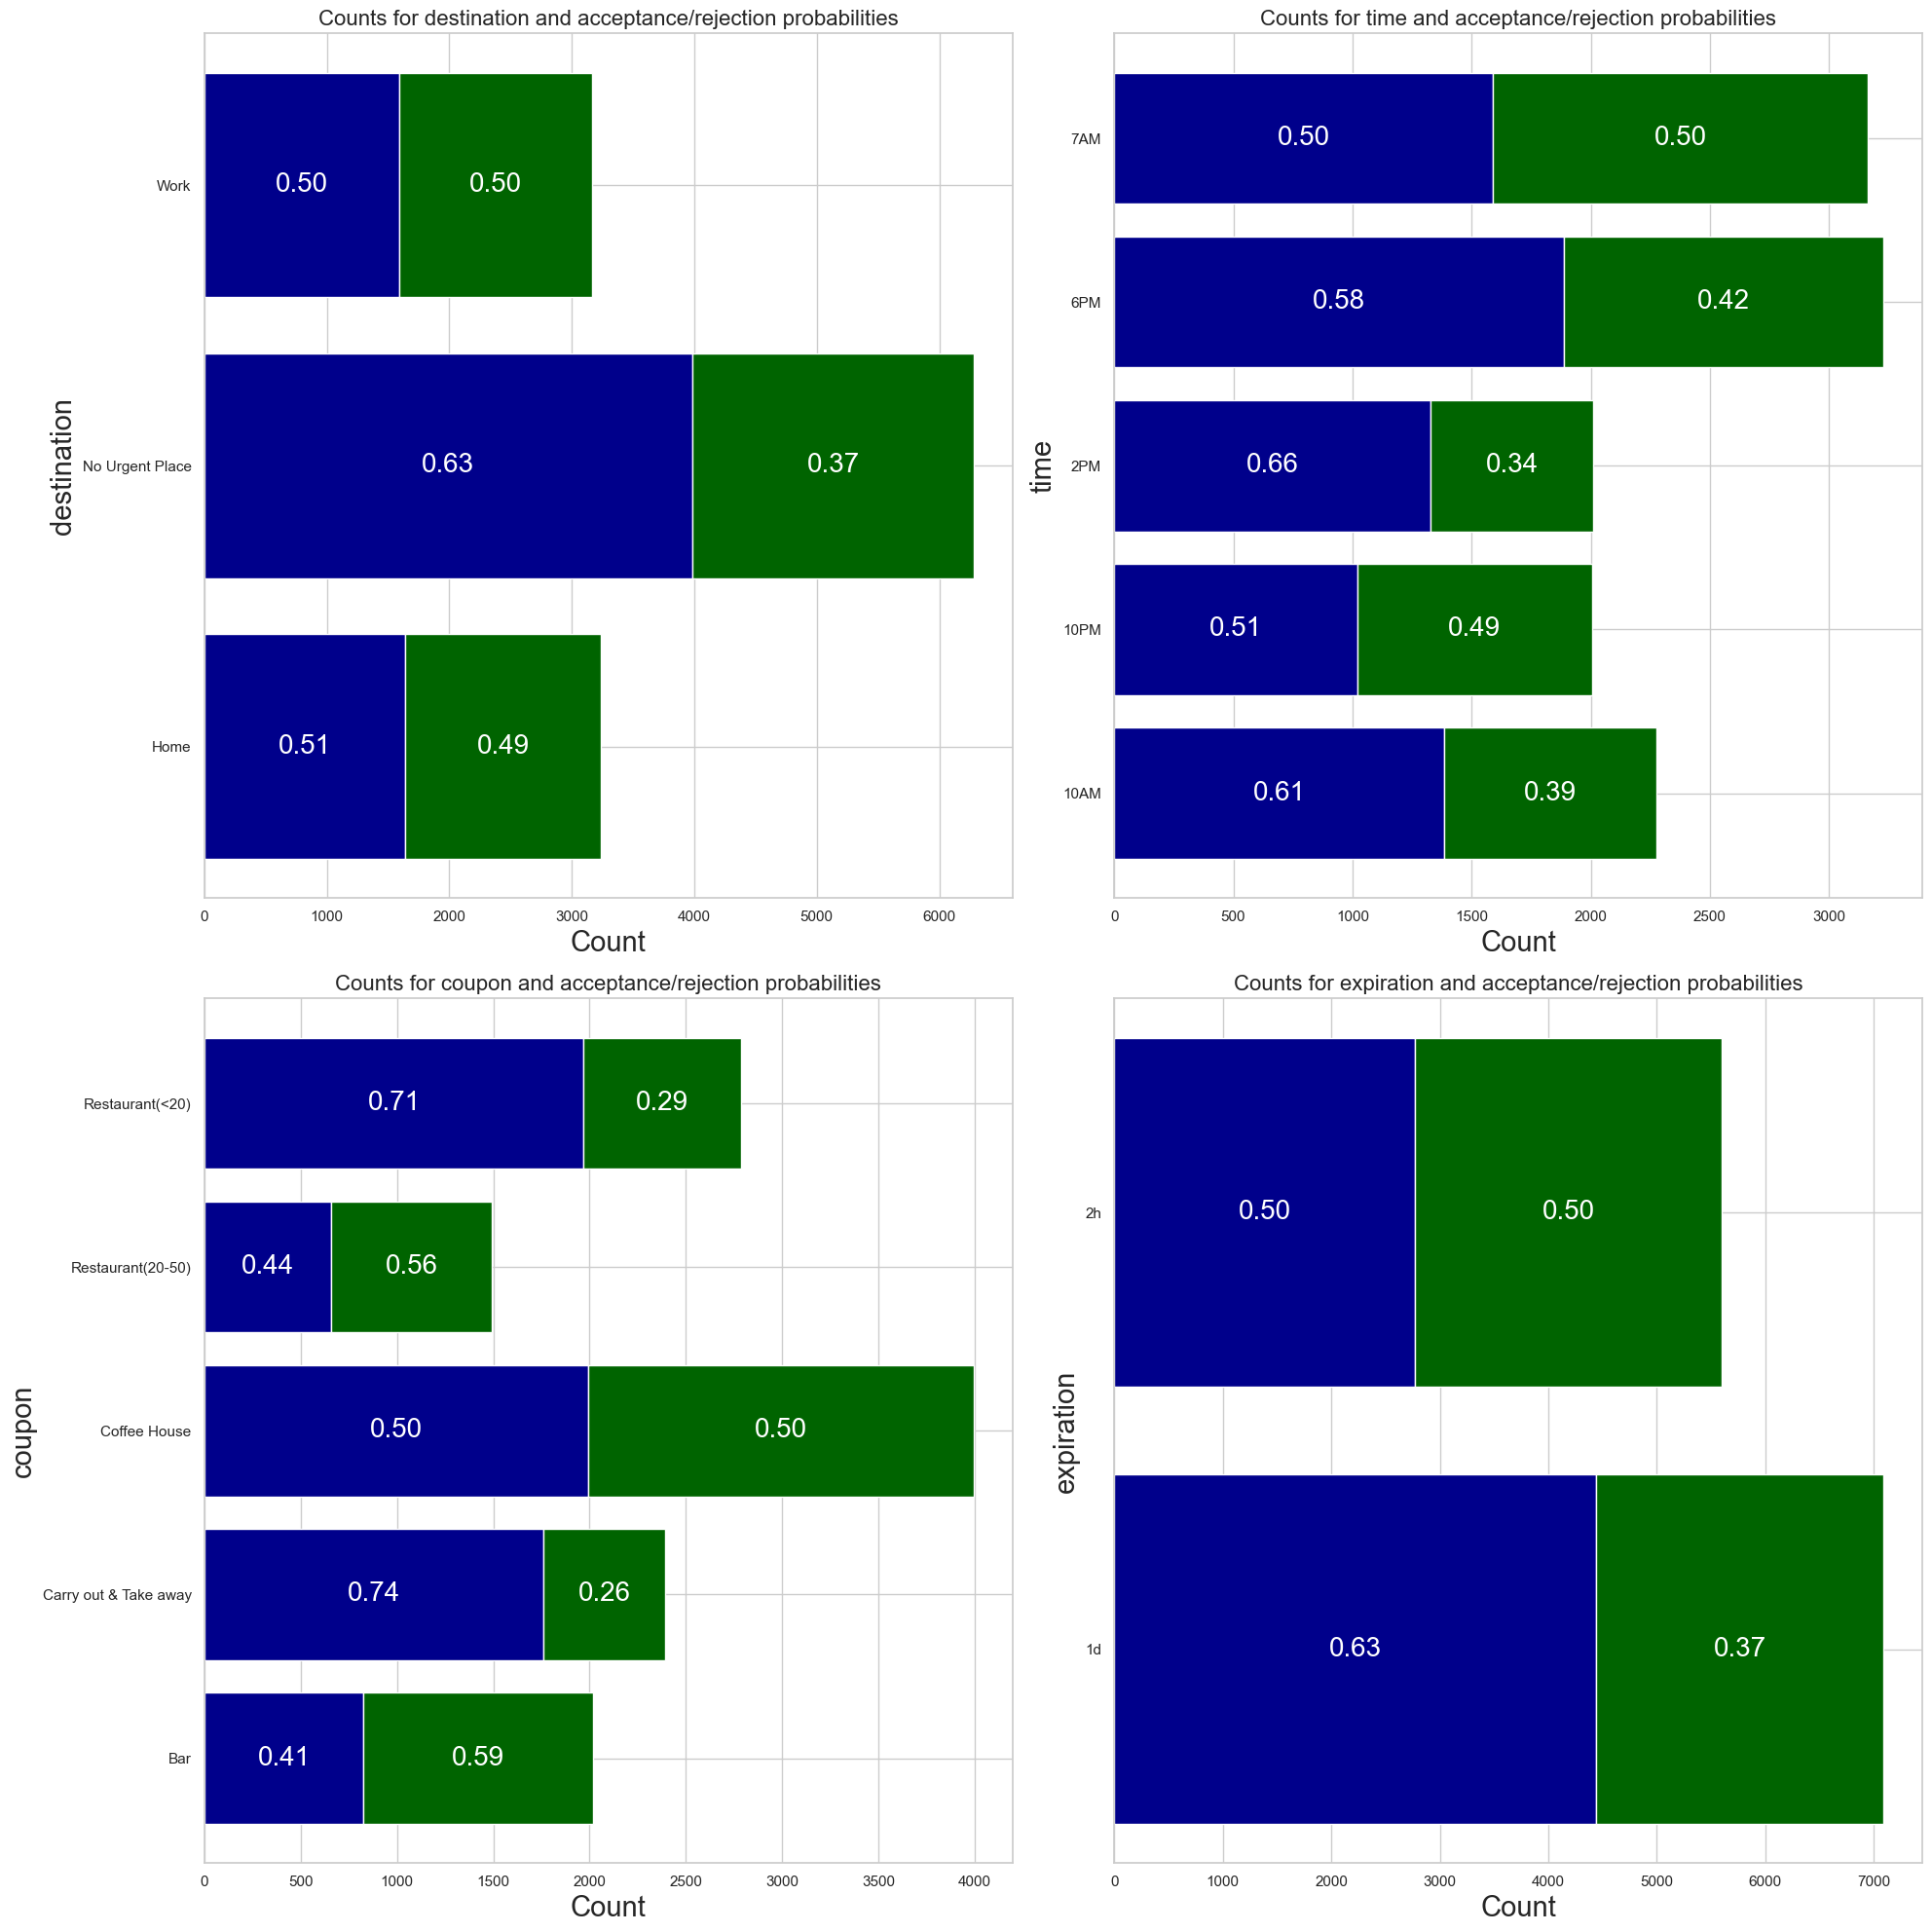

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

################################ CHECK WITH SOUSA ################################
df_test1 = data.copy() 
################################ CHECK WITH SOUSA ################################

# Set the style of the plots
sns.set(style="whitegrid")

# Define the columns to plot
columns_to_plot = ['destination', 'time', 'coupon', 'expiration']

# Calculate the number of rows and columns needed for the plots
n_rows = n_cols = int(np.ceil(np.sqrt(len(columns_to_plot))))

# Create a figure and axes with the right number of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

# Flatten the axes
axes = axes.flatten()

# Remove extra subplots
for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

# Display the bar plots for each specified column
for ax, column in zip(axes, columns_to_plot):
    data_no_na = data.dropna(subset=[column])
    counts_acceptance = data_no_na[data_no_na['Y'] == 1].groupby(column)['Y'].count().sort_index()
    counts_rejection = data_no_na[data_no_na['Y'] == 0].groupby(column)['Y'].count().sort_index()
    total_counts = counts_acceptance.add(counts_rejection, fill_value=0)
    probabilities_acceptance = (counts_acceptance / total_counts).sort_index()
    probabilities_rejection = (counts_rejection / total_counts).sort_index()
    ax.barh(y=counts_acceptance.index, width=counts_acceptance.values, color="darkblue")
    ax.barh(y=counts_rejection.index, width=counts_rejection.values, color="darkgreen", left=counts_acceptance.values)
    ax.set_title(f'Counts for {column} and acceptance/rejection probabilities', fontsize=16)
    ax.set_xlabel('Count', fontsize=21)
    ax.set_ylabel(column, fontsize=21)

    # Add probabilities on top of the bars
    for i, (prob_acceptance, prob_rejection) in enumerate(zip(probabilities_acceptance, probabilities_rejection)):
        ax.text(counts_acceptance[i]/2, i, '{:1.2f}'.format(prob_acceptance), ha="center", va="center", color="white",fontsize = 20)
        ax.text(counts_acceptance[i] + counts_rejection[i]/2, i, '{:1.2f}'.format(prob_rejection), ha="center", va="center", color="white", fontsize = 20)

plt.tight_layout()
plt.show()

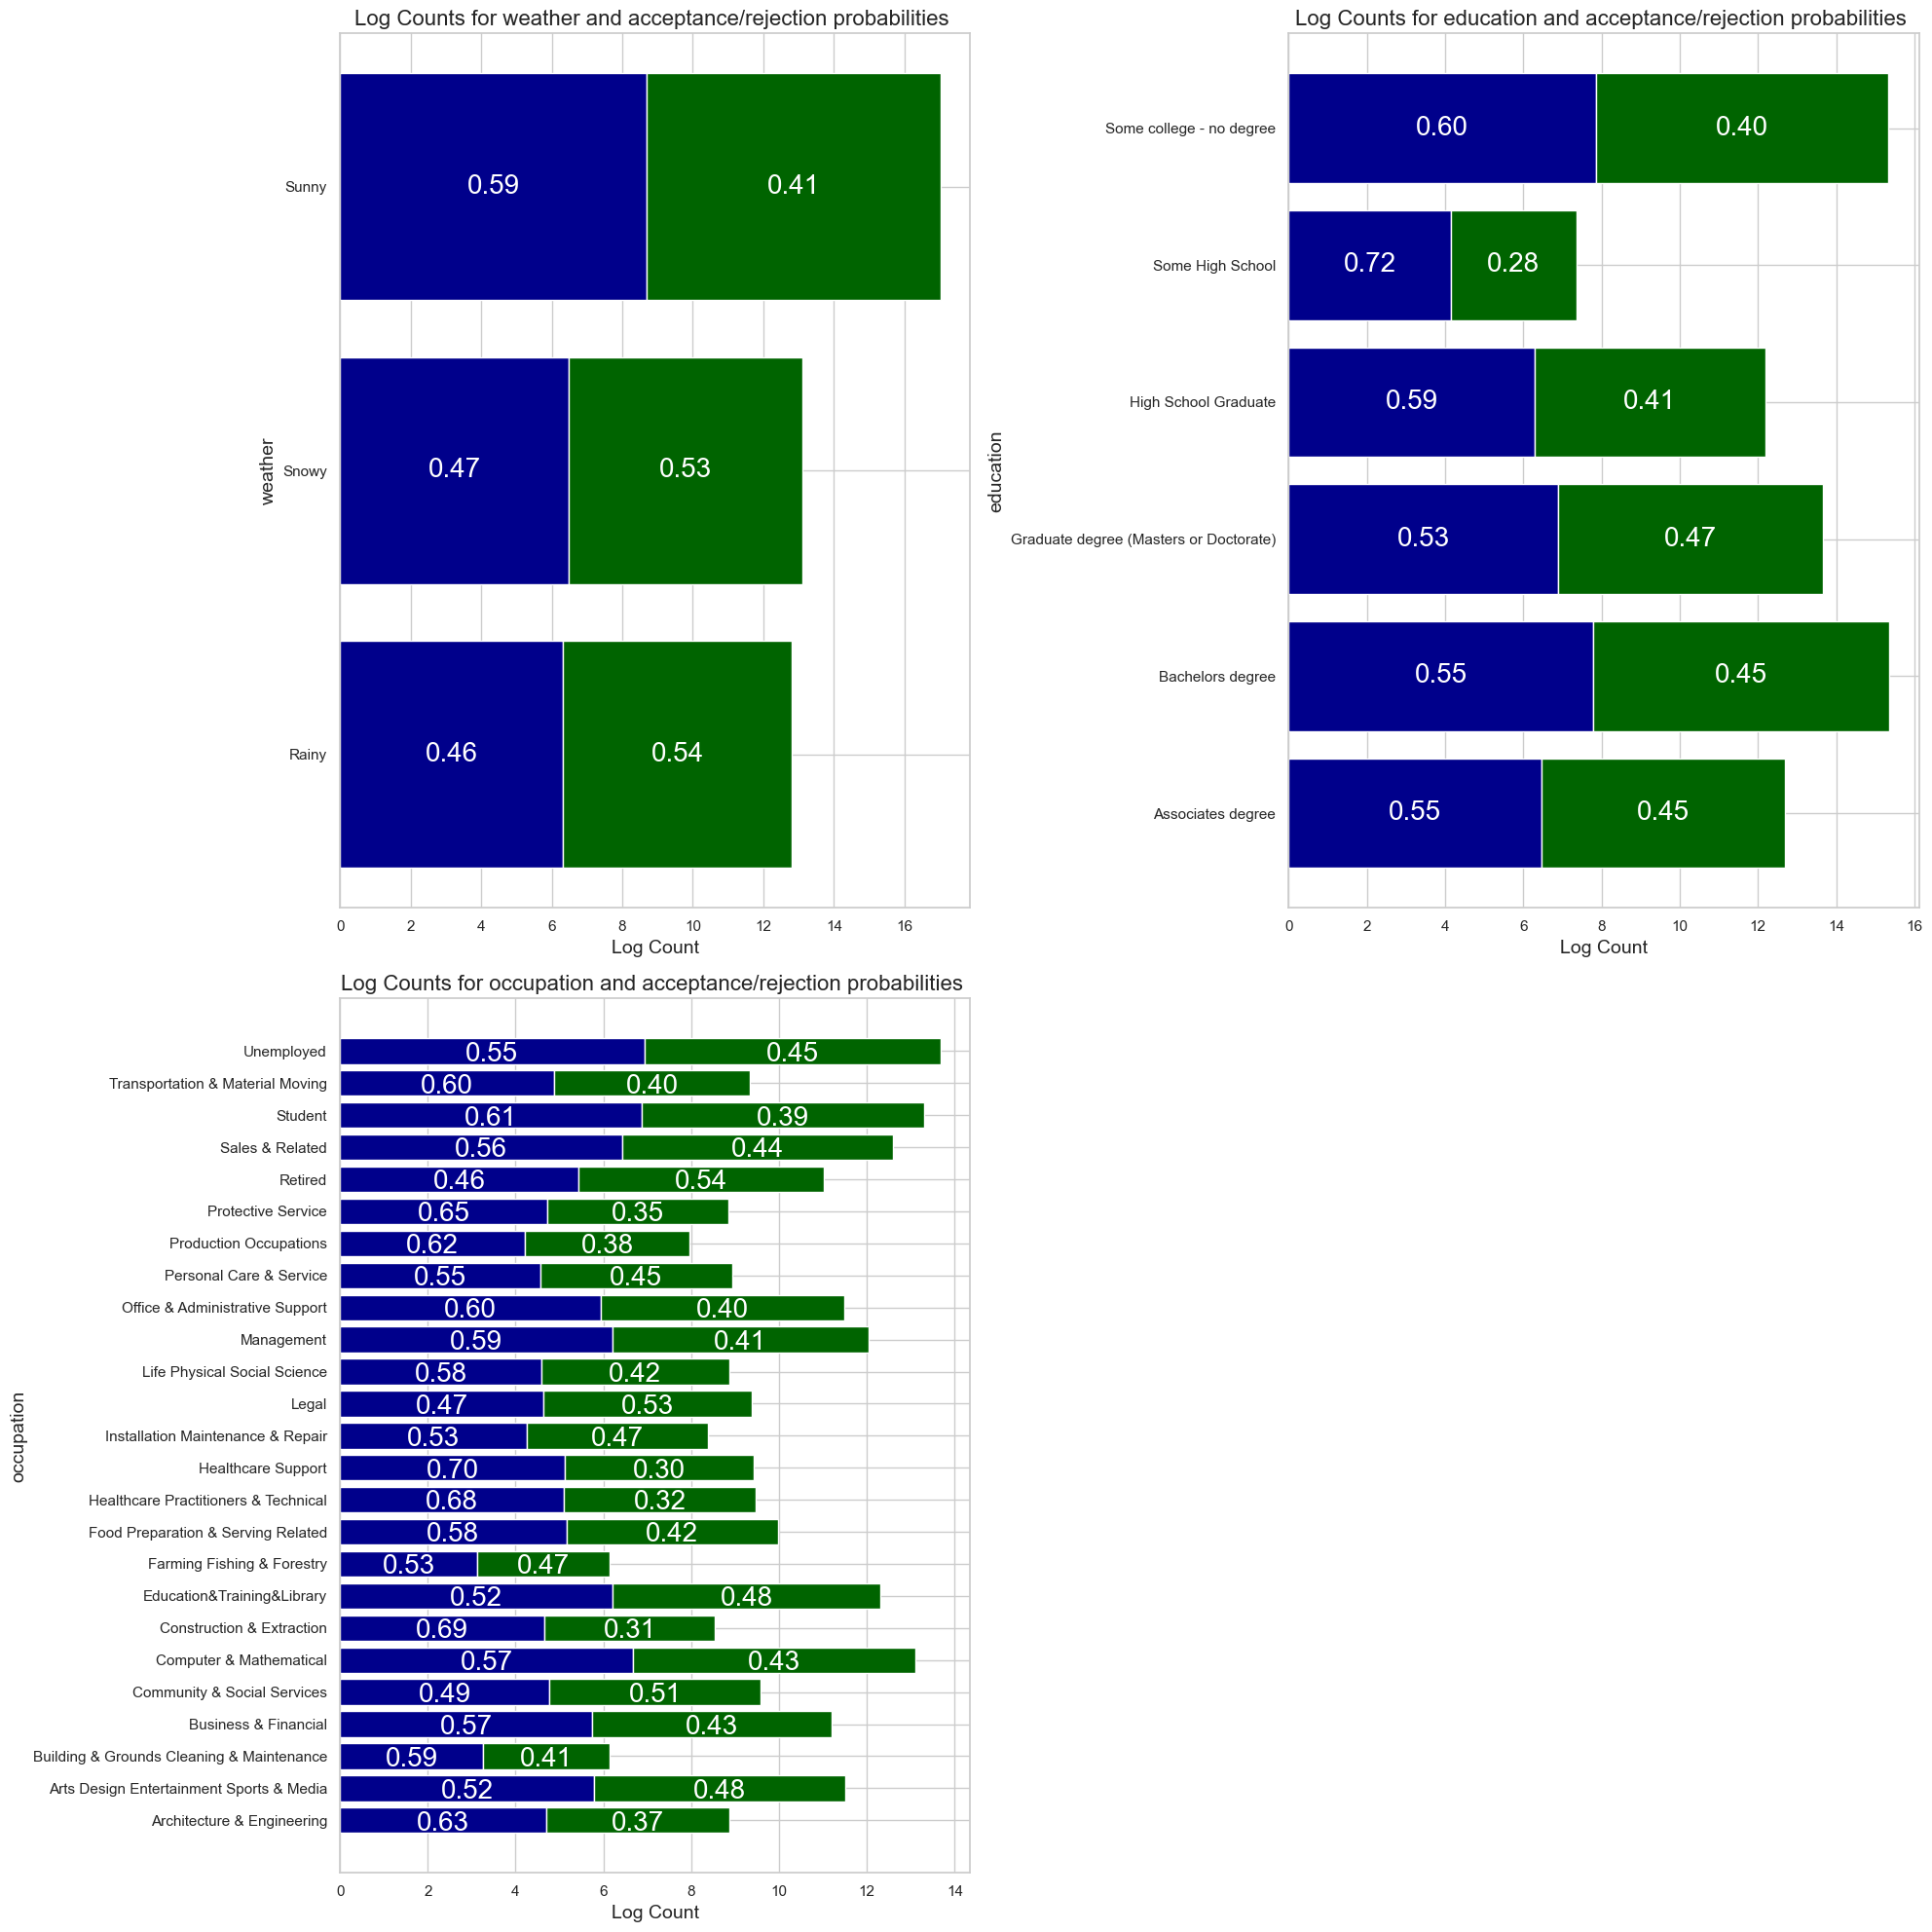

In [31]:
# Set the style of the plots
sns.set(style="whitegrid")

# Define the columns to plot
columns_to_plot = ['weather', 'education', 'occupation']

# Calculate the number of rows and columns needed for the plots
n_rows = n_cols = int(np.ceil(np.sqrt(len(columns_to_plot))))

# Create a figure and axes with the right number of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

# Flatten the axes
axes = axes.flatten()

# Remove extra subplots
for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

# Display the bar plots for each specified column
for ax, column in zip(axes, columns_to_plot):
    df_test1_no_na = df_test1.dropna(subset=[column])
    counts_acceptance = df_test1_no_na[df_test1_no_na['Y'] == 1].groupby(column)['Y'].count().sort_index()
    counts_rejection = df_test1_no_na[df_test1_no_na['Y'] == 0].groupby(column)['Y'].count().sort_index()
    total_counts = counts_acceptance.add(counts_rejection, fill_value=0)
    probabilities_acceptance = (counts_acceptance / total_counts).sort_index()
    probabilities_rejection = (counts_rejection / total_counts).sort_index()
    bars_acceptance = ax.barh(y=counts_acceptance.index, width=np.log(counts_acceptance.values), color="darkblue")
    bars_rejection = ax.barh(y=counts_rejection.index, width=np.log(counts_rejection.values), color="darkgreen", left=np.log(counts_acceptance.values))
    ax.set_title(f'Log Counts for {column} and acceptance/rejection probabilities ', fontsize=16)
    ax.set_xlabel('Log Count', fontsize=14)
    ax.set_ylabel(column, fontsize=14)

    # Add probabilities on top of the bars
    for i, (prob_acceptance, prob_rejection, bar_acceptance, bar_rejection) in enumerate(zip(probabilities_acceptance, probabilities_rejection, bars_acceptance, bars_rejection)):
        if column == 'occupation':
            ax.text(bar_acceptance.get_width()/2, bar_acceptance.get_y() + bar_acceptance.get_height()/2 - 0.1, '{:1.2f}'.format(prob_acceptance), ha="center", va="center", color="white", fontsize=20)
            ax.text(bar_acceptance.get_width() + bar_rejection.get_width()/2, bar_rejection.get_y() + bar_rejection.get_height()/2 - 0.1, '{:1.2f}'.format(prob_rejection), ha="center", va="center", color="white", fontsize=20)
        else:
            ax.text(bar_acceptance.get_width()/2, bar_acceptance.get_y() + bar_acceptance.get_height()/2, '{:1.2f}'.format(prob_acceptance), ha="center", va="center", color="white", fontsize=20)
            ax.text(bar_acceptance.get_width() + bar_rejection.get_width()/2, bar_rejection.get_y() + bar_rejection.get_height()/2, '{:1.2f}'.format(prob_rejection), ha="center", va="center", color="white", fontsize=20)

plt.tight_layout()
plt.show()

# Bivariate Analysis

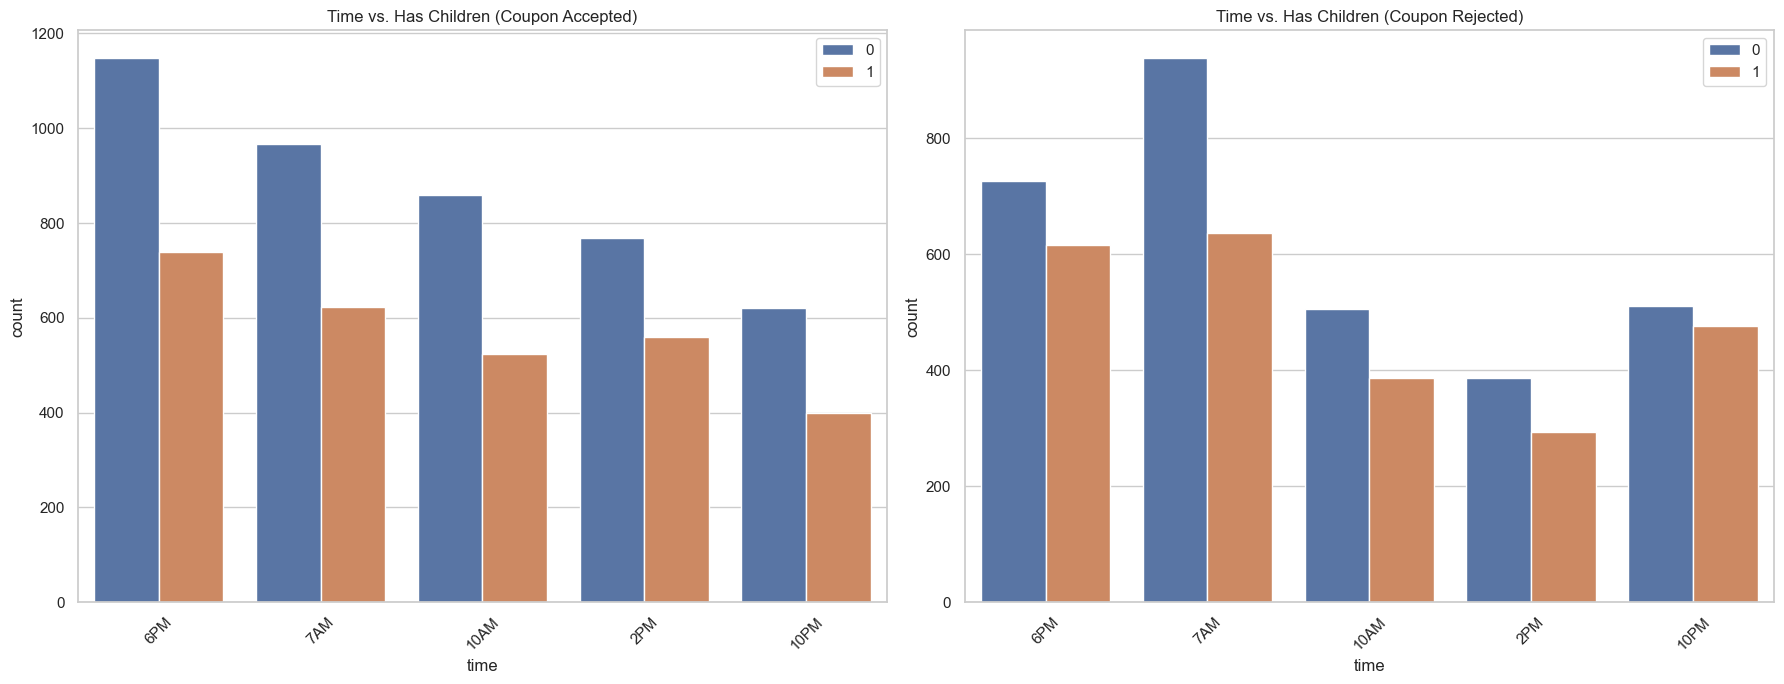

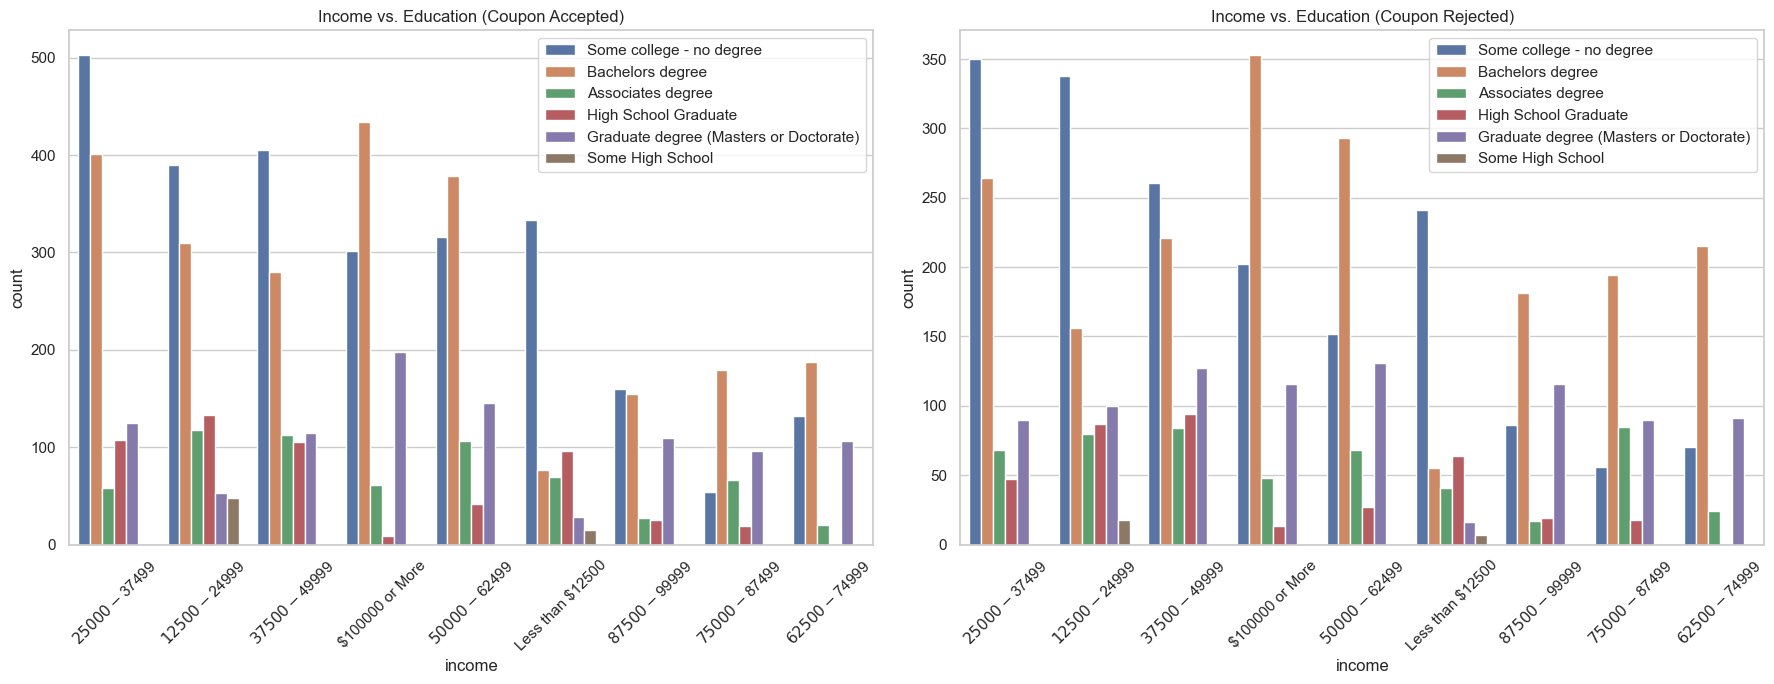

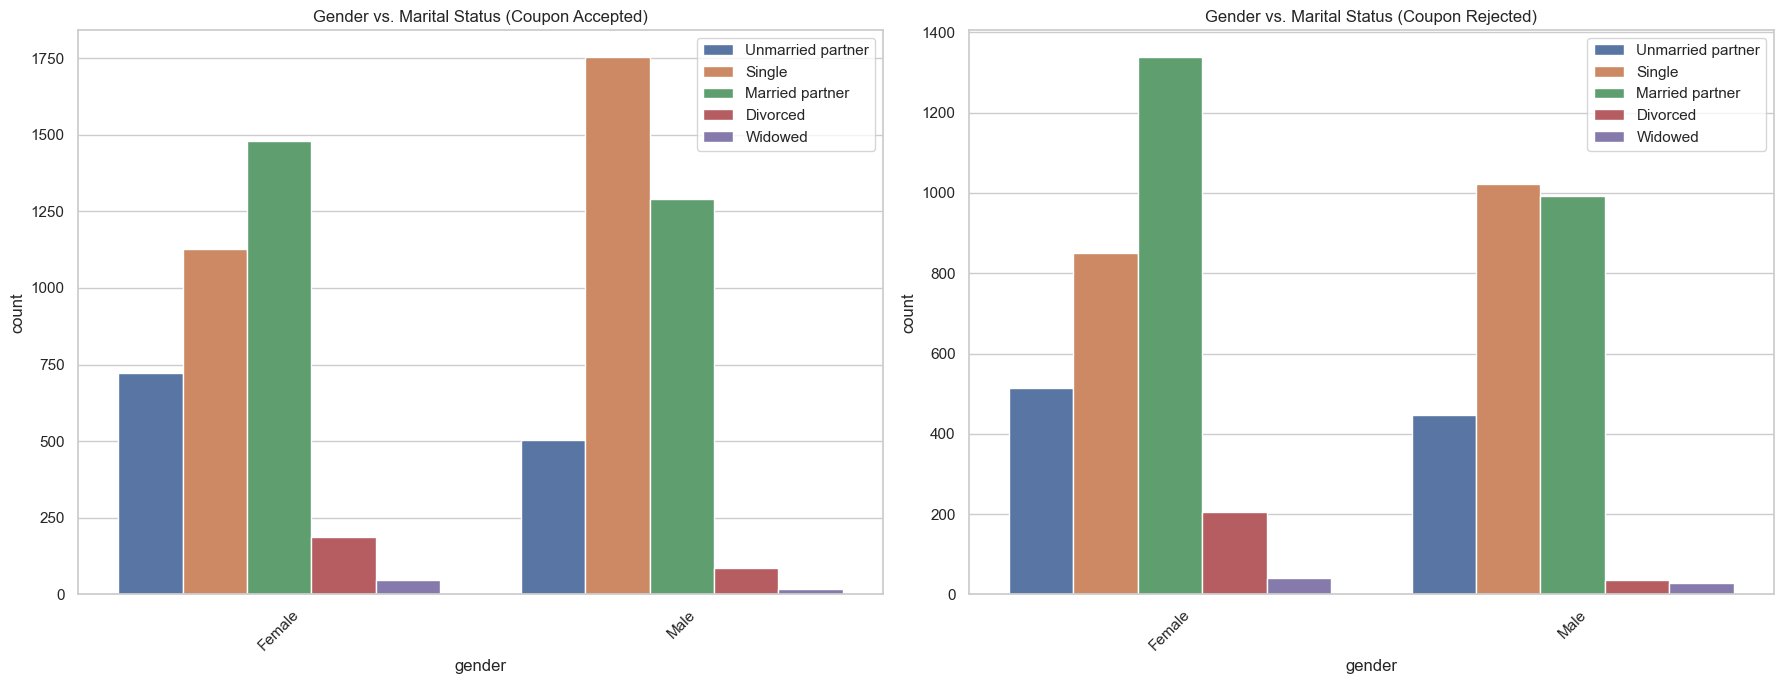

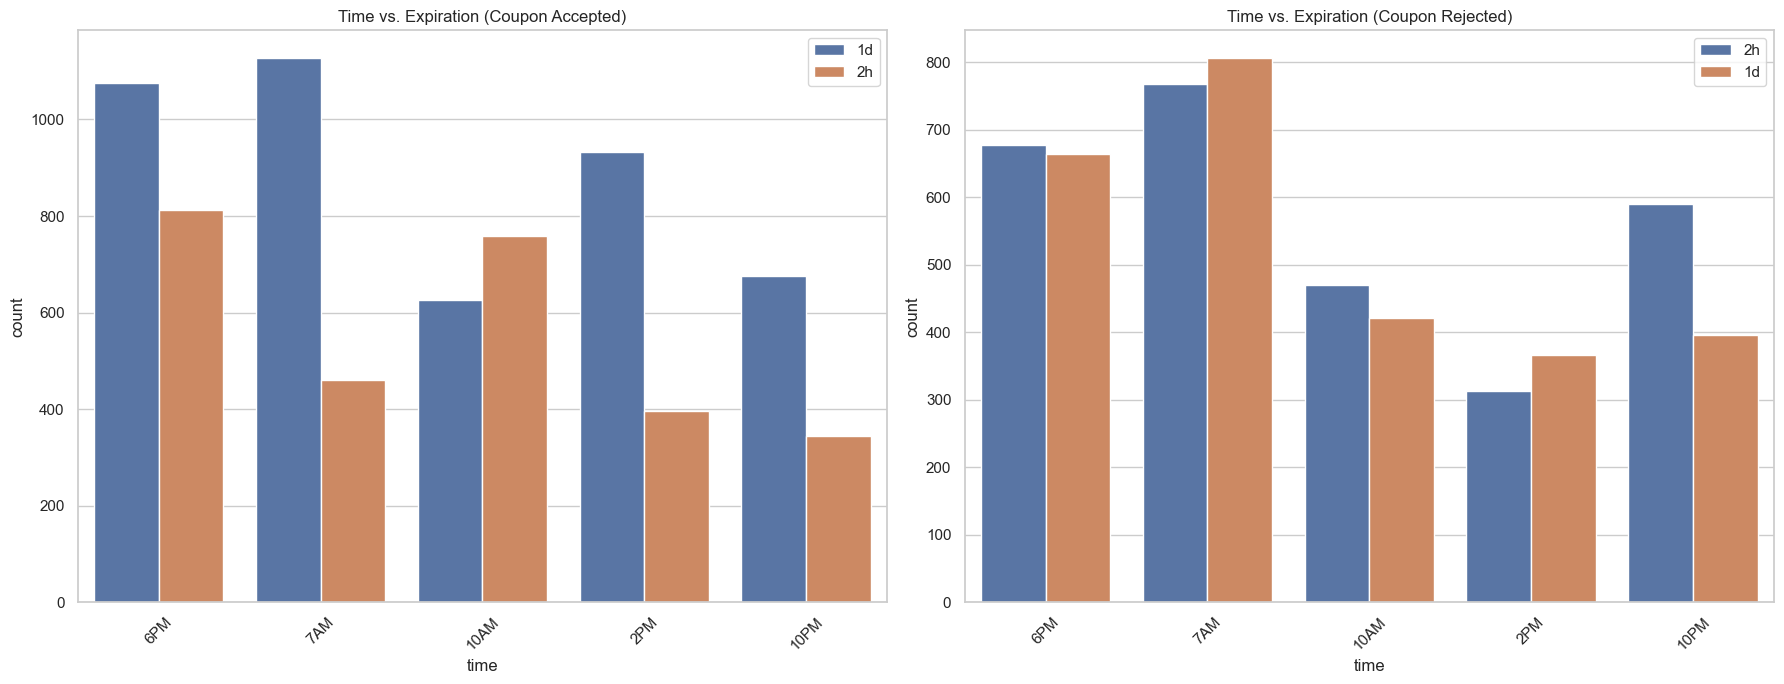

In [32]:
# Function to plot side-by-side comparisons
def plot_bivariate_side_by_side(data, x_var, hue_var, title):
    plt.figure(figsize=(18, 7))
    
    # Acceptance
    plt.subplot(1, 2, 1)
    sns.countplot(data=data[data['Y'] == 1], x=x_var, hue=hue_var, order=data[x_var].value_counts().index)
    plt.title(f'{title} (Coupon Accepted)')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    
    # Rejection
    plt.subplot(1, 2, 2)
    sns.countplot(data=data[data['Y'] == 0], x=x_var, hue=hue_var, order=data[x_var].value_counts().index)
    plt.title(f'{title} (Coupon Rejected)')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# 1. Time and Has_Children
plot_bivariate_side_by_side(df_test1, 'time', 'has_children', 'Time vs. Has Children')

# 2. Income and Education
plot_bivariate_side_by_side(df_test1, 'income', 'education', 'Income vs. Education')

# 3. Gender and Marital Status
plot_bivariate_side_by_side(df_test1, 'gender', 'maritalStatus', 'Gender vs. Marital Status')

# 4. Time and Expiration
plot_bivariate_side_by_side(df_test1, 'time', 'expiration', 'Time vs. Expiration')


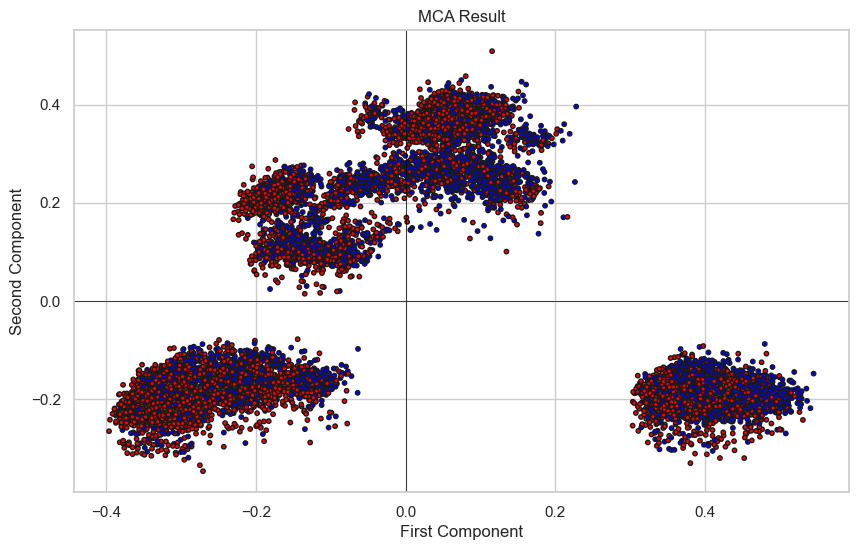

In [93]:
# Apply MCA
mca = prince.MCA(n_components=2, n_iter=3, random_state=42)
mca_result = mca.fit_transform(df_ready.iloc[:, :-1])

# Define colors based on 'Y' column
colors = ['red' if y == 1 else 'blue' for y in df_ready['Y']]

# Plotting using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(mca_result[0], mca_result[1], edgecolor='k', s=10, c=colors)
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('MCA Result')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()

# Imputation

In [90]:
df.iloc[:, :-1]

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,0,0,0,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,0,0,0,1
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,1,0,0,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,1,0,0,1
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,0,0,1,0
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,0,0,0,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,0,0,1,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,1,1,0,1


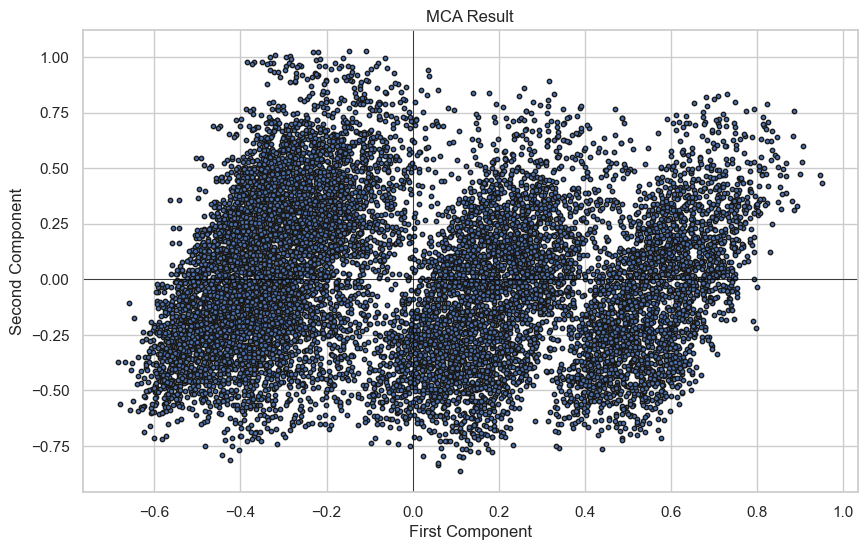

In [89]:
# Apply MCA
mca = prince.MCA(n_components=2, n_iter=3, random_state=42)
mca_result = mca.fit_transform(df.iloc[:, :-1])

# Plotting using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(mca_result[0], mca_result[1], edgecolor='k', s=10)
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('MCA Result')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()

In [34]:
df_test1 = df.copy()

df_test1 = remove_dup(df_test1)
df_test1 = value_mapping(df_test1)
df_test1 = drop_columns(df_test1)

In [35]:
# Load data
df_clean = df_test1.copy()

In [36]:
# show missing values per column
df_clean.isna().sum() 

destination               0
passanger                 0
weather                   0
temperature               0
time                      0
coupon                    0
expiration                0
gender                    0
age                       0
maritalStatus             0
has_children              0
education                 0
occupation                0
income                    0
Bar                     107
CoffeeHouse             217
CarryAway               150
RestaurantLessThan20    129
Restaurant20To50        189
toCoupon_GEQ5min          0
toCoupon_GEQ15min         0
toCoupon_GEQ25min         0
direction_same            0
Y                         0
dtype: int64

In [37]:
# Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50 intercepted NAN
# Get index of NAN values of BAR column
index_bar = df_clean[df_clean['Bar'].isna()].index.tolist()
index_coffeehouse = df_clean[df_clean['CoffeeHouse'].isna()].index.tolist()
index_carryaway = df_clean[df_clean['CarryAway'].isna()].index.tolist()
index_restaurantless20 = df_clean[df_clean['RestaurantLessThan20'].isna()].index.tolist()
index_restaurant20to50 = df_clean[df_clean['Restaurant20To50'].isna()].index.tolist()

# Intersect all indexes
index_intercept_NAN = list(set(index_bar) & set(index_coffeehouse) & set(index_carryaway) & set(index_restaurantless20) & set(index_restaurant20to50))

### Mode imputation

In [38]:
# Load data
df_clean_mode = pd.read_csv('cleaned_dataset_without_inputation.csv')

# df with missing values
df_clean_missing_values = pd.read_csv('cleaned_dataset_without_inputation.csv')

# Drop rows with NAN values
df_clean_mode = df_clean_mode.drop(index_intercept_NAN)

# Do imputation with mode
df_clean_mode = df_clean_mode.fillna(df_clean_mode.mode().iloc[0])

### Decision Tree imputation

In [39]:
# Drop rows with NAN values
df_clean = df_clean.drop(index_intercept_NAN)

In [40]:
columns_to_impute = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
# get columns and subtract columns to impute
columns_to_dummy = list(set(df_clean.columns) - set(columns_to_impute))

# Pass nominal columns to dummy variables
df_clean_dummies = pd.get_dummies(df_clean, columns=columns_to_dummy, drop_first=True)

In [41]:
from sklearn.tree import DecisionTreeClassifier

# Columns to impute
columns_to_impute = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

# Function to impute missing values using Decision Trees
def impute_with_decision_tree(data, column_to_impute, features):
    # Split data into train and predict sets
    train_data = data[data[column_to_impute].notna()]
    predict_data = data[data[column_to_impute].isna()]
    
    # Train a decision tree classifier
    clf = DecisionTreeClassifier()
    clf.fit(train_data[features], train_data[column_to_impute])
    
    # Predict missing values
    if not predict_data.empty:
        predicted_values = clf.predict(predict_data[features])
        data.loc[data[column_to_impute].isna(), column_to_impute] = predicted_values

    return data

# Features to use for imputation
features = df_clean_dummies.drop(columns=columns_to_impute).columns.tolist()

# Impute missing values for each column
for column in columns_to_impute:
    df_clean_dummies = impute_with_decision_tree(df_clean_dummies, column, features)

# Now substitute NAN values with the values imputeted in df_clean_dummies in df_clean
df_clean['Bar'] = df_clean_dummies['Bar']
df_clean['CoffeeHouse'] = df_clean_dummies['CoffeeHouse']
df_clean['CarryAway'] = df_clean_dummies['CarryAway']
df_clean['RestaurantLessThan20'] = df_clean_dummies['RestaurantLessThan20']
df_clean['Restaurant20To50'] = df_clean_dummies['Restaurant20To50']

# Check if there are still NAN values
df_clean.isna().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
Y                       0
dtype: int64

In [42]:
# Compare coffeehouse column from df_clean and df_clean_mode
print(df_clean['CoffeeHouse'].value_counts())
print(df_clean_mode['CoffeeHouse'].value_counts())
print(df_clean_missing_values['CoffeeHouse'].value_counts())

CoffeeHouse
1.0    3407
2.0    3283
0.0    2956
3.0    1802
4.0    1120
Name: count, dtype: int64
CoffeeHouse
1.0    3537
2.0    3199
0.0    2946
3.0    1779
4.0    1107
Name: count, dtype: int64
CoffeeHouse
1.0    3362
2.0    3199
0.0    2946
3.0    1779
4.0    1107
Name: count, dtype: int64


In [86]:
df_clean.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y
0,No Urgent Place,Alone,Sunny,1,2PM,Restaurant(<20),1d,Female,1,Unmarried partner,...,0.0,0.0,2.0,3.0,2.0,1,0,0,0,1
1,No Urgent Place,Friend(s),Sunny,2,10AM,Coffee House,2h,Female,1,Unmarried partner,...,0.0,0.0,2.0,3.0,2.0,1,0,0,0,0
2,No Urgent Place,Friend(s),Sunny,2,10AM,Carry out & Take away,2h,Female,1,Unmarried partner,...,0.0,0.0,2.0,3.0,2.0,1,1,0,0,1
3,No Urgent Place,Friend(s),Sunny,2,2PM,Coffee House,2h,Female,1,Unmarried partner,...,0.0,0.0,2.0,3.0,2.0,1,1,0,0,0
4,No Urgent Place,Friend(s),Sunny,2,2PM,Coffee House,1d,Female,1,Unmarried partner,...,0.0,0.0,2.0,3.0,2.0,1,1,0,0,0


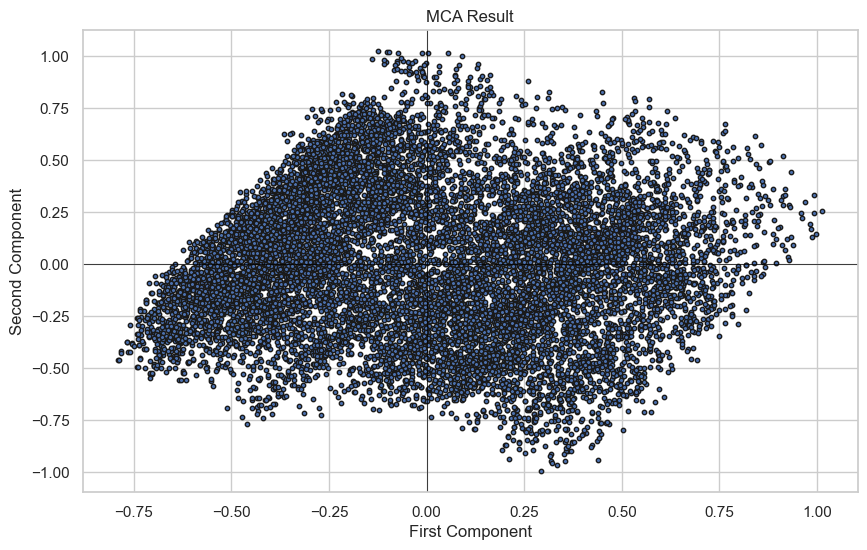

In [87]:
# Apply MCA
mca = prince.MCA(n_components=2, n_iter=6, random_state=42)
mca_result = mca.fit_transform(df_clean.iloc[:, :-1])

# Plotting using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(mca_result[0], mca_result[1], edgecolor='k', s=10)
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('MCA Result')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()

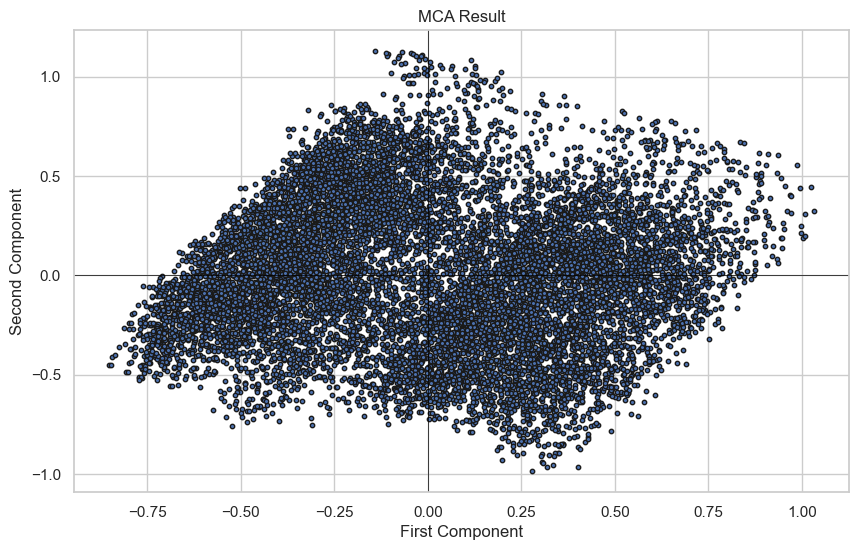

In [88]:
mca = prince.MCA(n_components=2, n_iter=6, random_state=42)
mca_result = mca.fit_transform(df_clean_mode.iloc[:, :-1])

# Plotting using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(mca_result[0], mca_result[1], edgecolor='k', s=10)
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('MCA Result')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()

# Feature Engineering

## toCoupon_GEQ

In [45]:
# combine toCoupon_GEQ5min’, toCoupon_GEQ15min’ and ‘toCoupon_GEQ25min’ into one column 0, 1, 2 values

#0: driving distance is less than or equal to 15 min
#1: driving distance is greater than 15 min and less than or equal to 25 min
#2: driving distance is greater than 25 min

def combine_distance_columns(df):
    """
    Combine 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', and 'toCoupon_GEQ25min' 
    columns into a single column 'to_coupon'.
    
    Parameters:
    - df (pd.df_test1Frame): The input df_test1est1frame
    
    Returns:
    - df (pd.df_test1est1Frame): The modifdf_tdf_tdf_test1df_tdf_tdf_tdf_tdf_tdf_tdf_tdf_tdf_tdf_tdf_tdf_tdf_tdf_tdf_tdf_tdf_tdf_test1df_test1frame with the 'to_coupon' column
    """
    
    def assign_to_coupon(row):
        if row['toCoupon_GEQ25min'] == 1:
            return 2
        elif row['toCoupon_GEQ15min'] == 1:
            return 1
        else:
            return 0

    # add the new column at penultimate position (before 'Y')
    df.insert(len(df.columns) - 1, 'to_coupon', np.nan)
    df['to_coupon'] = df.apply(assign_to_coupon, axis=1)

    # Drop the original columns
    df.drop(['toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min'], axis=1, inplace=True)
    
    return df


- Removed duplicates
- Applied ordinal encoding to the obvious variables (i.e. Age, Income, Temperature, the 5 frequency variables)
- Dropped car
- to_Coupon_GEQ

In [46]:
df_test1 = combine_distance_columns(df_test1)

## Age taxonomy

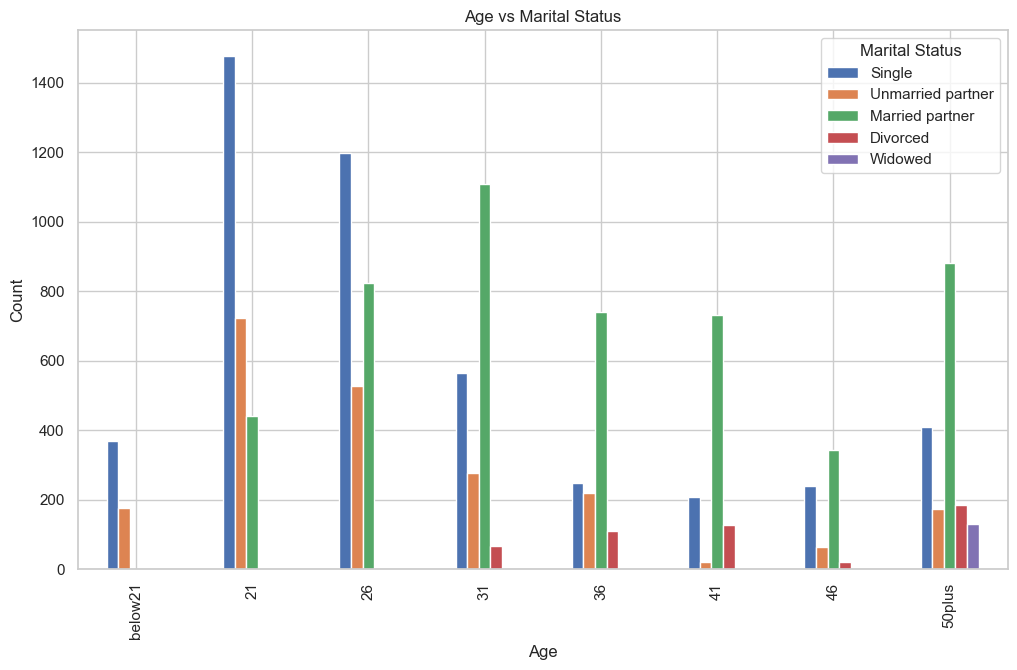

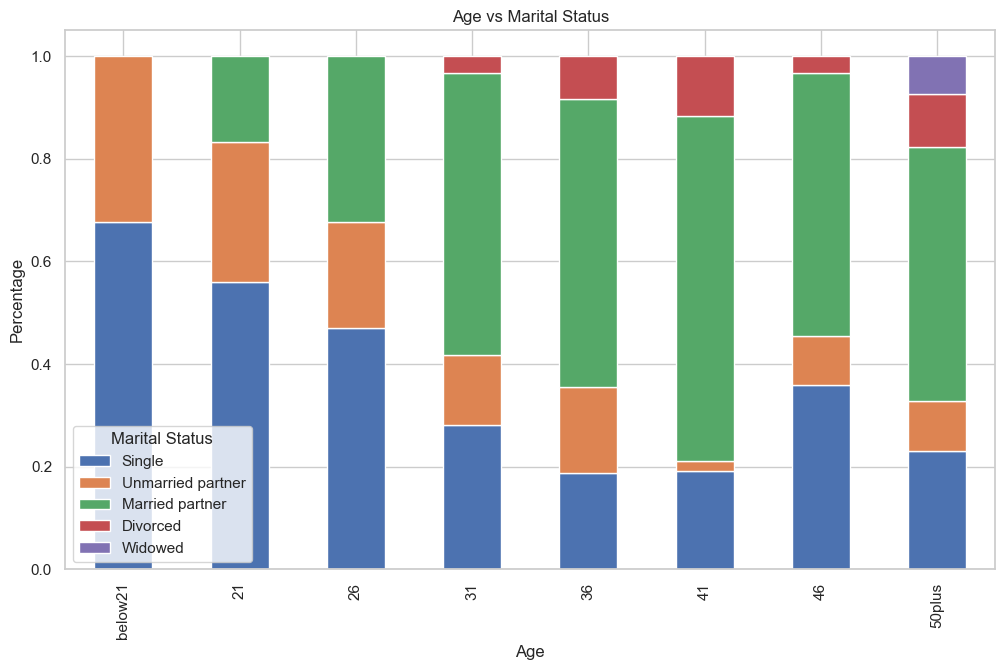

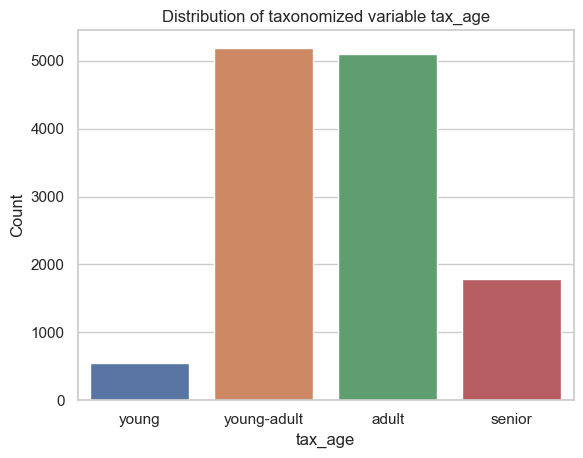

In [47]:
# analyzing age with the help of marital status

# defining 'age' categories order for visualization
custom_order_Age = [0, 1, 2, 3, 4, 5, 6, 7]

# defining 'maritalStatus' categories order for visualization
custom_order_MS = ['Single','Unmarried partner','Married partner','Divorced','Widowed']

# defining the x-axis legend
x_axis = ['below21', '21', '26', '31', '36', '41', '46', '50plus']

# pivoting the data to get counts of each combination
pivot_df = df_test1.groupby(['age', 'maritalStatus']).size().unstack().fillna(0)

# ordering the data based on the custom orders
pivot_df = pivot_df.reindex(custom_order_Age)[custom_order_MS]

# plotting grouped bar plot
pivot_df.plot(kind='bar', figsize=(12, 7), stacked=False)
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(custom_order_Age, x_axis)
plt.title('Age vs Marital Status')
plt.legend(title='Marital Status')
plt.show()


####################

# redoing this, but to analyze the percentage of each marital status per age group instead of raw counts
pivot_df = df_test1.groupby(['age', 'maritalStatus']).size().unstack().fillna(0)
pivot_df = pivot_df.reindex(custom_order_Age)[custom_order_MS]
pivot_df = pivot_df.apply(lambda x: x/x.sum(), axis=1)
pivot_df.plot(kind='bar', figsize=(12, 7), stacked=True)
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.xticks(custom_order_Age, x_axis)
plt.title('Age vs Marital Status')
plt.legend(title='Marital Status')
plt.show()

# now, we create the new taxonomized variable 'tax_age'
# along the rules:
# 0: below 21         (0)                (young)
# 1: 21, 26           (1,2)              (young-adult)
# 2: 31, 36, 41, 46   (3,4,5,6)          (adult)
# 3: 50plus           (7)                (senior)

df_test1['tax_age'] = df_test1['age'].apply(lambda x: 0 if x == 0 else (1 if x in [1, 2] else (2 if x in [3, 4, 5, 6] else 3)))

# visualizing its distribution
sns.countplot(x='tax_age', data=df_test1)
plt.xlabel('tax_age')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3], ['young', 'young-adult', 'adult', 'senior'])
plt.title('Distribution of taxonomized variable tax_age')
plt.show()

## Coupon Importance

### First we create: Coupon total frequency

In [48]:
# {'never': 0,'less1': 1,'1~3': 2,'4~8': 3,'gt8': 4}


# summing all this up
def create_coupon_freq_total(number_used_for_gt8, df):
    # first, we need to encode the 5 coupon variables: 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'Bar'
    # using the mean of each interval as the value to be encoded (what about for gt8?)

    coupon_names = ['CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'Bar']
    for coupon_name in coupon_names:
        df['mean_' + coupon_name] = df[coupon_name].apply(lambda x: 0 if x == 0 else (1 if x == 1 else (2 if x == 2 else (6 if x == 3 else number_used_for_gt8))))

    # creating a new variable called coupon_freq_total which is the sum of all the coupon frequency variables
    coupon_freq_total = df['mean_CoffeeHouse'] + df['mean_CarryAway'] + df['mean_RestaurantLessThan20'] + df['mean_Restaurant20To50'] + df['mean_Bar']
    return coupon_freq_total


# creating a new variable called coupon_freq_total which is the sum of all the coupon frequency variables
number_used_for_gt8 = 9
df_test1['coupon_freq_total'] = create_coupon_freq_total(number_used_for_gt8, df_test1)


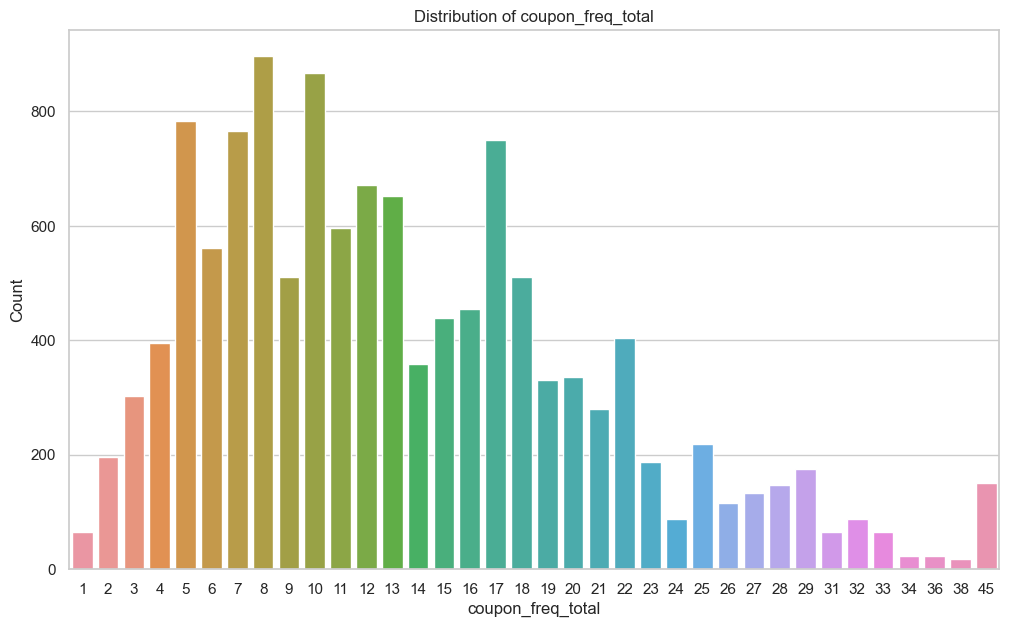

In [49]:
# checking the new variable coupon_freq_total

# value counts
#print(df_test1['coupon_freq_total'].value_counts())
# bar plot for bar distribution
plt.figure(figsize=(12, 7))
sns.countplot(x='coupon_freq_total', data=df_test1)
plt.xlabel('coupon_freq_total')
plt.ylabel('Count')
plt.title('Distribution of coupon_freq_total')
plt.show()

In [50]:
# does coupon_freq_total have 0s?
print('coupon_freq_total has', len(df_test1[df_test1['coupon_freq_total'] == 0]), '"0s".')

coupon_freq_total has 0 "0s".


Now, we will use this new variable to create the one we actually want: the importance of the given coupon for the given user. We will call this variable `coupon_importance`. 

Comes from dividing the coupon frequency by the total frequency of the user. E.g. if coupon = 'Bar', then coupon_importance = Bar_frequency / coupon_total_frequency.

In [51]:
# Vectorized computation of coupon_importance
def compute_importance(row):

    # Mapping coupon to respective frequency columns
    coupon_to_freq_mapping = {
        'Coffee House': 'mean_CoffeeHouse',
        'Carry out & Take away': 'mean_CarryAway',
        'Restaurant(<20)': 'mean_RestaurantLessThan20',
        'Restaurant(20-50)': 'mean_Restaurant20To50',
        'Bar': 'mean_Bar'
    }

    given_coupon = coupon_to_freq_mapping[row['coupon']]
    total_freq = row['coupon_freq_total']
    return row[given_coupon] / total_freq if total_freq else 0

df_test1['coupon_importance'] = df_test1.apply(compute_importance, axis=1)

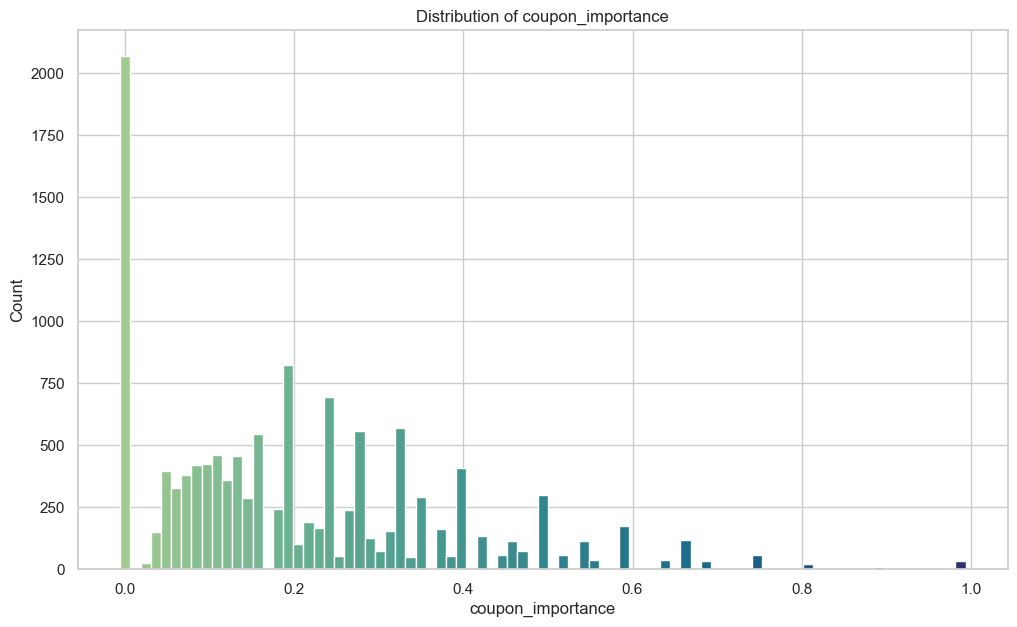

In [52]:
# visualizing new variable coupon_importance distribution

# determining unique values and the number of bins
bins = df_test1['coupon_importance'].nunique()
values, edges = np.histogram(df_test1['coupon_importance'], bins=bins)

colors = sns.color_palette("crest", bins)
plt.figure(figsize=(12, 7))
for i in range(bins):
    plt.bar(edges[i], values[i], width=edges[i+1]-edges[i], color=colors[i])
plt.xlabel('coupon_importance')
plt.ylabel('Count')
plt.title('Distribution of coupon_importance')
plt.show()

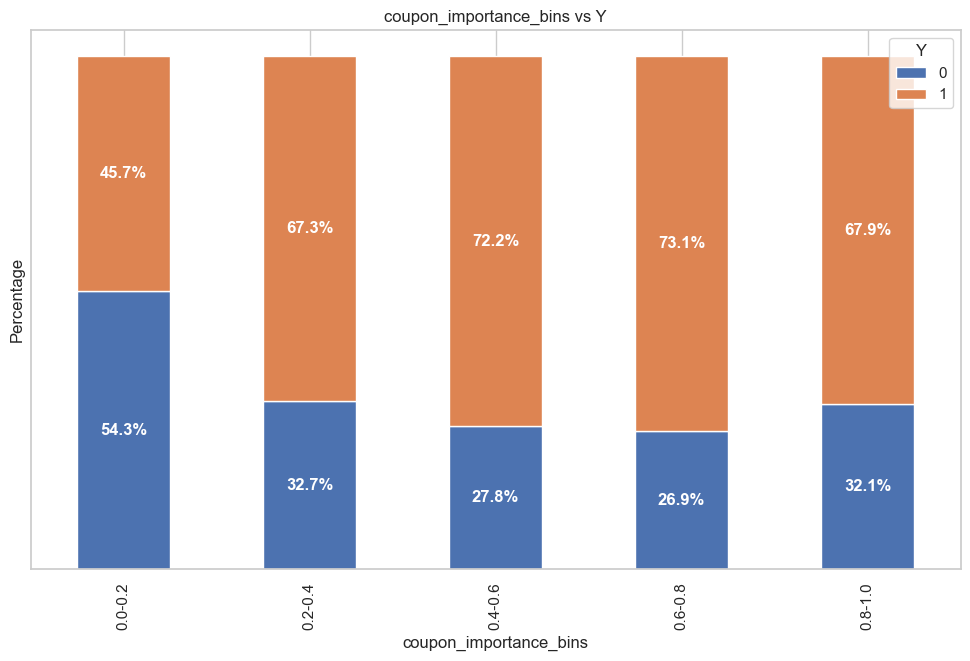

In [53]:
# creating a function to plot the percentage of each category of a feature vs the target variable
def feature_vs_target(df, feature, target, returnQ = False, plotQ = True):
    """
    Plots a bar plot of the percentage of each category of the feature vs the target variable.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe
    - feature (str): The feature column name
    - target (str): The target column name
    
    Returns:
    - None
    """
    
    # Calculating counts for each category
    grouped = df.groupby([feature, target]).size().unstack(fill_value=0)

    # Calculating percentages
    grouped_percentage = grouped.divide(grouped.sum(axis=1), axis=0) * 100



    
    
    if returnQ == True:
        return grouped_percentage
    
    if plotQ == True:
        # Plotting
        ax = grouped_percentage.plot(kind='bar', stacked=True, figsize=(12,7))
        plt.title(feature + ' vs ' + target)
        plt.xlabel(feature)
        plt.ylabel('Percentage')
        plt.yticks([])  # Hide yticks

        # Display percentages on the bars
        for index, rect in enumerate(ax.patches):
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2

            # Choose the y-value based on the height of the bar segment
            vertical_position = rect.get_y() + y_value / 2

            label = "{:.1f}%".format(y_value)
            ax.annotate(label, (x_value, vertical_position), xytext=(0, 0),
                        textcoords="offset points", ha='center', va='center', color='white', weight='bold')        
        plt.show()


# binning coupon_importance
n_bins = 5
bins = np.arange(0, 1+1/n_bins, 1/n_bins)
labels = [str(round(float(bins[i]), 3)) + '-' + str(round(float(bins[i+1]), 3)) for i in range(n_bins)]



df_test1['coupon_importance_bins'] = pd.cut(df_test1['coupon_importance'], bins=bins, labels=labels, right=False)

# plotting coupon_importance_bins vs Y
feature_vs_target(df_test1, 'coupon_importance_bins', 'Y')

In [54]:
# this is where we searched for a nice value for number_used_for_gt8, 
# one that at least orders P(Y=1 | Coupon Importance) in ascending order

'''
number_used_for_gt8 = 9
values_that_work = []
while number_used_for_gt8 in range(9,100):

    df_test1['coupon_freq_total'] = create_coupon_freq_total(number_used_for_gt8, df_test1)
    df_test1['coupon_importance'] = df_test1.apply(compute_importance, axis=1)
    # binning coupon_importance
    n_bins = 5
    bins = np.arange(0, 1+1/n_bins, 1/n_bins)
    labels = [str(round(float(bins[i]), 3)) + '-' + str(round(float(bins[i+1]), 3)) for i in range(n_bins)]
    df_test1['coupon_importance_bins'] = pd.cut(df_test1['coupon_importance'], bins=bins, labels=labels, right=False)
    # plotting coupon_importance_bins vs Y
    prob_data = feature_vs_target(df_test1, 'coupon_importance_bins', 'Y', returnQ=True, plotQ=False)

    # extracting only the Y=1 probabilities
    prob_data = prob_data[1]

    # checking if these probabilities are in ascending order
    if prob_data.is_monotonic_increasing:
        values_that_work.append(number_used_for_gt8)

    # printing at each 100th iteration
    if number_used_for_gt8 % 25 == 0:
        print('number_used_for_gt8 =', number_used_for_gt8, 'examined.')
    
    number_used_for_gt8 += 1
    

print('Values that work:', values_that_work)
'''

# With n_bins = 5
# range(9, 100)
# Values that work: [16, 17, 18]

"\nnumber_used_for_gt8 = 9\nvalues_that_work = []\nwhile number_used_for_gt8 in range(9,100):\n\n    df_test1['coupon_freq_total'] = create_coupon_freq_total(number_used_for_gt8, df_test1)\n    df_test1['coupon_importance'] = df_test1.apply(compute_importance, axis=1)\n    # binning coupon_importance\n    n_bins = 5\n    bins = np.arange(0, 1+1/n_bins, 1/n_bins)\n    labels = [str(round(float(bins[i]), 3)) + '-' + str(round(float(bins[i+1]), 3)) for i in range(n_bins)]\n    df_test1['coupon_importance_bins'] = pd.cut(df_test1['coupon_importance'], bins=bins, labels=labels, right=False)\n    # plotting coupon_importance_bins vs Y\n    prob_data = feature_vs_target(df_test1, 'coupon_importance_bins', 'Y', returnQ=True, plotQ=False)\n\n    # extracting only the Y=1 probabilities\n    prob_data = prob_data[1]\n\n    # checking if these probabilities are in ascending order\n    if prob_data.is_monotonic_increasing:\n        values_that_work.append(number_used_for_gt8)\n\n    # printing at e

Is the probability of Y=1 in ascending order? True


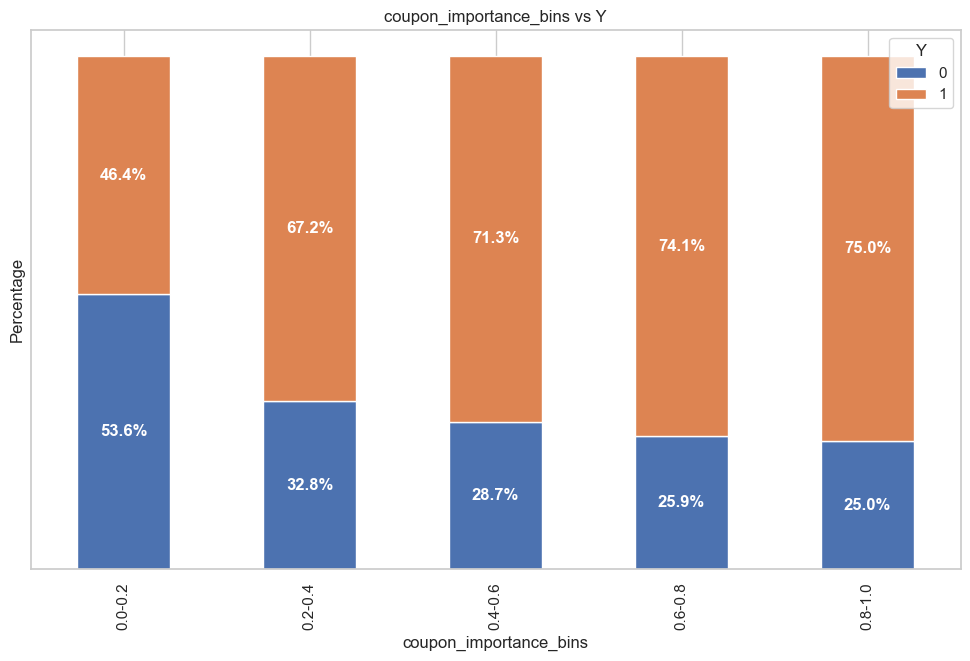

In [55]:
# testing with number_used_for_gt8 = 16 and n_bins = 5

number_used_for_gt8 = 16
df_test1['coupon_freq_total'] = create_coupon_freq_total(number_used_for_gt8, df_test1)
df_test1['coupon_importance'] = df_test1.apply(compute_importance, axis=1)
# binning coupon_importance
n_bins = 5
bins = np.arange(0, 1+1/n_bins, 1/n_bins)
labels = [str(round(float(bins[i]), 3)) + '-' + str(round(float(bins[i+1]), 3)) for i in range(n_bins)]
df_test1['coupon_importance_bins'] = pd.cut(df_test1['coupon_importance'], bins=bins, labels=labels, right=False)
# plotting coupon_importance_bins vs Y
prob_data = feature_vs_target(df_test1, 'coupon_importance_bins', 'Y', returnQ=True)

# extracting only the Y=1 probabilities
prob_data = prob_data[1]

# checking if these probabilities are in ascending order
print('Is the probability of Y=1 in ascending order?', prob_data.is_monotonic_increasing)

feature_vs_target(df_test1, 'coupon_importance_bins', 'Y')

## Occupation taxonomy

In [56]:
occupation_mapping = {
    'Unemployed': 'Students & Unemployed',
    'Student': 'Students & Unemployed',
    'Retired': 'Students & Unemployed',
    
    'Computer & Mathematical': 'Tech & Engineering',
    'Architecture & Engineering': 'Tech & Engineering',
    
    'Sales & Related': 'Sales & Finance',
    'Business & Financial': 'Sales & Finance',
    
    'Education&Training&Library': 'Education & Training',
    
    'Management': 'Management & Admin',
    'Office & Administrative Support': 'Management & Admin',
    
    'Arts Design Entertainment Sports & Media': 'Arts & Entertainment',
    
    'Food Preparation & Serving Related': 'Food & Hospitality',
    
    'Doctor': 'Healthcare',
    'Nurse': 'Healthcare',
    'Healthcare Practitioners & Technical': 'Healthcare',
    'Healthcare Support': 'Healthcare',
    
    'Community & Social Services': 'Community & Legal',
    'Legal': 'Community & Legal',
    
    'Transportation & Material Moving': 'Transport & Construction',
    'Construction & Extraction': 'Transport & Construction',
    
    'Life Physical Social Science': 'Science & Environment',
    'Farming Fishing & Forestry': 'Science & Environment',
    
    'Installation Maintenance & Repair': 'Maintenance & Production',
    'Production Occupations': 'Maintenance & Production',
    'Building & Grounds Cleaning & Maintenance': 'Maintenance & Production',
    
    'Protective Service': 'Protective & Personal Services',
    'Personal Care & Service': 'Protective & Personal Services',
}

''' 
df_test1['occupation_category'] = df_test1['occupation'].map(occupation_mapping)

# visualize occupation_category distribution
plt.figure(figsize=(12, 7))
sns.countplot(x='occupation_category', data=df_test1)
plt.xlabel('occupation_category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Distribution of occupation_category')
plt.show()
'''


#df = df.drop('occupation', axis=1) # no longer doing this

" \ndf_test1['occupation_category'] = df_test1['occupation'].map(occupation_mapping)\n\n# visualize occupation_category distribution\nplt.figure(figsize=(12, 7))\nsns.countplot(x='occupation_category', data=df_test1)\nplt.xlabel('occupation_category')\nplt.ylabel('Count')\nplt.xticks(rotation=45)\nplt.title('Distribution of occupation_category')\nplt.show()\n"

## Time

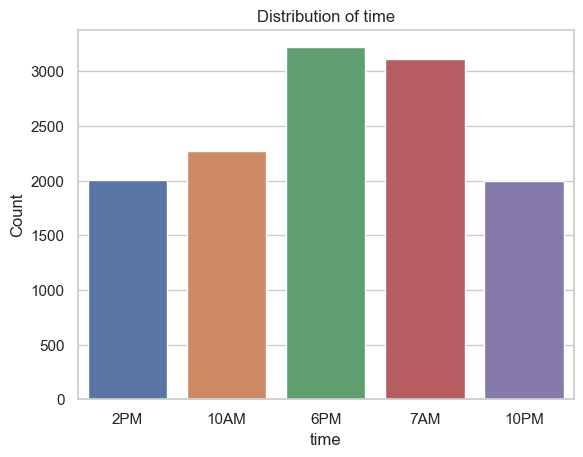

In [57]:
# sns countplot of time
sns.countplot(x='time', data=df_test1)
plt.xlabel('time')
plt.ylabel('Count')
plt.title('Distribution of time')
plt.show()

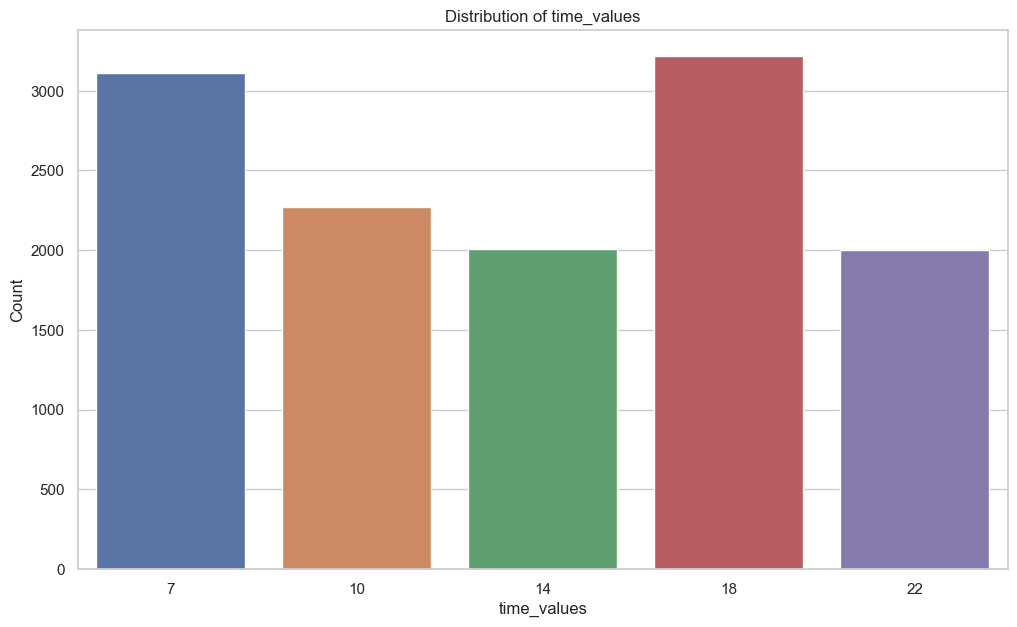

In [58]:
# time as it is, is currently categorical, although it clearly is an ordinal variable

# as such, we tried two different approaches to encode it:

# 1: direct value mapping
# i.e. 7AM -> 7, 10AM -> 10, 2PM -> 14, 6PM -> 18, 10PM -> 22
df_test1['time_values'] = df_test1['time'].apply(lambda x: 7 if x == '7AM' else (10 if x == '10AM' else (14 if x == '2PM' else (18 if x == '6PM' else 22))))

# 2: sin and cos encoding, encoding the cyclic nature of time, through a bundle of two variables
# i.e. time_sin = sin(2 * pi * time / 24)
#  and time_cos = cos(2 * pi * time / 24)
df_test1['time_sin'] = df_test1['time_values'].apply(lambda x: np.sin(2 * np.pi * x / 24))
df_test1['time_cos'] = df_test1['time_values'].apply(lambda x: np.cos(2 * np.pi * x / 24))

# checking the new variables
# time_values bar plot
plt.figure(figsize=(12, 7))
sns.countplot(x='time_values', data=df_test1)
plt.xlabel('time_values')
plt.ylabel('Count')
plt.title('Distribution of time_values')
plt.show()

# 2nd approach: time_sin and time_cos distribution, in the following cells

In [59]:
# let's create a function that transforms clock hours into "naive hours" i.e. as if they were "polar hours", but always from 0 to 12 
# i.e. a function unclockify such that
# unclockify(0) = 3
# unclockify(3) = 0
# unclockify(6) = 9
# unclockify(9) = 6
# unclockify(12) = 3

def unclockify(hour):
    return 3 - hour if hour <= 3 else 15 - hour

# let's visually test if this function works, through a plot
# first, let's create a list of clock hours
clock_hours = list(range(24))

# now, let's create a list of "naive hours"/"polar hours"
naive_hours = [unclockify(hour) for hour in clock_hours]

print('Clock hours:', clock_hours)
print('Naive hours:', naive_hours)

print('\n')

print('The unclockify function does work as intended!')

Clock hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Naive hours: [3, 2, 1, 0, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, -1, -2, -3, -4, -5, -6, -7, -8]


The unclockify function does work as intended!


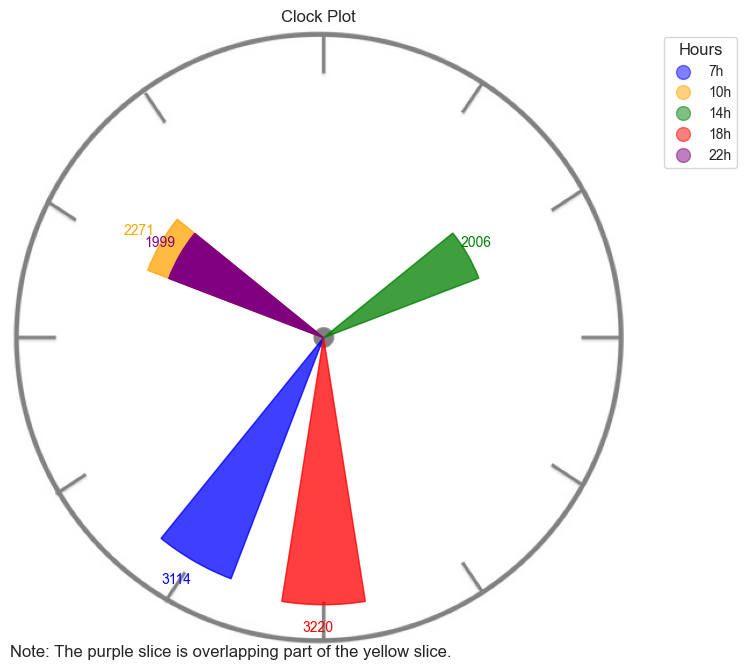

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

# Assume df_test1 exists with 'time_values', 'time_sin', 'time_cos' columns.

# Extract unique hours
unique_hours = df_test1['time_values'].unique()

fig, ax = plt.subplots(figsize=(8, 8))

# number of visible hours to be represented, since it is a clock
n_hours = 12 
# Define the radius and width for the slices
radius = 1 #1.47 isn't bad

# label factor for adjusting the label position
label_factor = 1.1

color_index = 0
all_hours = range(25)
for hour in all_hours:
    # necessary hour conversion, since a polar plot is anticlockwise
    # through the usage of the clockify function
    
    center_coords = (0.027,0)

    # assigning different colors for each unique hour 
    colors_used = ['blue', 'orange', 'green', 'red', 'purple']
    if hour in unique_hours:
        plot_hour = unclockify(hour)
        # Calculate the starting and ending angles for each slice
        adjust_size_slice=45/5

        start_angle = 360 * ((plot_hour) / n_hours) - adjust_size_slice
        end_angle = start_angle +2 * adjust_size_slice

        # instead of fixed radius, the radius will be determined by the value count
        radius = df_test1['time_values'].value_counts()[hour]
        # adjusting from a to b
        a = 0
        b = 1.3
        freq = df_test1['time_values'].value_counts()[hour]
        radius = freq/max(df_test1['time_values'].value_counts())*(b-a)+a
        
        # Create a wedge (slice) for the given hour
        wedge = Wedge(center=center_coords, r=radius, theta1=start_angle, theta2=end_angle, color=colors_used[color_index], alpha=0.5) #Wedge(center=center_coords, r=radius, theta1=start_angle, theta2=end_angle, width=width, color='blue', alpha=0.5)
        ax.add_patch(wedge)
        # exception: 10AM and 10PM do coincide on the clock slice
        if hour == 22: # 10AM_freq > 10PM_freq (by examination)
            wedge = Wedge(center=center_coords, r=radius, theta1=start_angle, theta2=end_angle,color=colors_used[color_index], alpha=1)
        # adding the wedge to the plot, i.e. the slice
        ax.add_patch(wedge)

        # Label the slice
        adjust_radius_factor = 1.00
        label_angle = np.radians(start_angle + (end_angle-start_angle)/2)  # Adjusting used to be manual, but using the middle of the slice is better
        ax.annotate(f'{freq}', xy=(np.cos(label_angle)*radius*adjust_radius_factor, np.sin(label_angle)*radius*adjust_radius_factor), xytext=(label_factor*np.cos(label_angle)*radius*adjust_radius_factor, label_factor*np.sin(label_angle)*radius*adjust_radius_factor),
                    ha='center', fontsize=10, color = colors_used[color_index], alpha=1)
        

        # adding label to match colors to each hour, with plt
        plt.scatter([], [], c=colors_used[color_index], alpha=0.5, s=100, label=str(hour)+'h')
        plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Hours', fontsize=10)


        
        color_index += 1
    

''' meant to draw the 12 hour numbers on the clock
    if 0<hour<=12:

        radius = 1.2

        plot_hour = unclockify(hour)

        # here, we create a hollow slice
        # Calculate the starting and ending angles for each slice
        start_angle = 360 * (plot_hour / n_hours)
        end_angle = start_angle + 360 / n_hours

        # Create a wedge (slice) for the given hour
        wedge = Wedge(center=center_coords, r=radius, theta1=start_angle, theta2=end_angle, color='black', alpha=0.0)
        ax.add_patch(wedge)

        # Label the slice
        adjust_radius_factor = 1
        label_angle = np.radians(start_angle)  # Adjusting used to be manual, but using the middle of the slice is better
        ax.annotate(f'{hour}', xy=(np.cos(label_angle)*radius*adjust_radius_factor, np.sin(label_angle)*radius*adjust_radius_factor), xytext=(label_factor*np.cos(label_angle)*radius*adjust_radius_factor, label_factor*np.sin(label_angle)*radius*adjust_radius_factor),
                    ha='center', fontsize=10, color ='teal')
'''


# Adjusting the axis and title
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.axis('off')  # Turn off the axis
ax.set_title("Clock Plot")
# combining this plot with an image as background (of a clock)
clock_image = plt.imread('../Images/clock3.png') # clock3 works
ax.imshow(clock_image, extent=[-1.5, 1.5, -1.5, 1.5], alpha=0.5)

# adding note to bottom left saying "each slice represents frequence of given hour class"
plt.text(-1.5,-1.55,"Note: The purple slice is overlapping part of the yellow slice.")
plt.show()

## Expiration date

In [61]:
# transformning into binary variable
# 0: 2h
# 1: 1d

df_test1['expiration_binary'] = df_test1['expiration'].apply(lambda x: 0 if x == '2h' else 1)

## Education

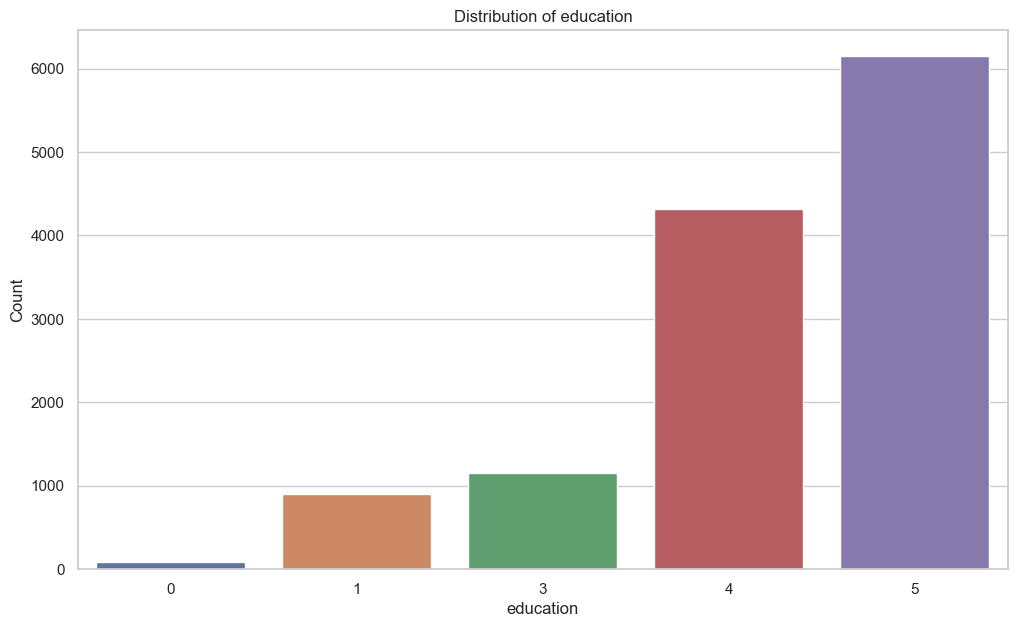

In [62]:
# defining its order
custom_order_edu = ['Some High School', 'High School Graduate', 'Some College - no degree', 'Associates degree', 'Bachelors degree', 'Graduate degree']

# let's transform the variable into an ordinal variable
# 0: Some High School
# 1: High School Graduate
# 2: Some College - no degree
# 3: Associates degree
# 4: Bachelors degree
# 5: Graduate degree

df_test1['education'] = df_test1['education'].apply(lambda x: 0 if x == 'Some High School' else (1 if x == 'High School Graduate' else (2 if x == 'Some College - no degree' else (3 if x == 'Associates degree' else (4 if x == 'Bachelors degree' else 5)))))

# let's check education distribution
plt.figure(figsize=(12, 7))
sns.countplot(x='education', data=df_test1)
plt.xlabel('education')
plt.ylabel('Count')
plt.title('Distribution of education')
plt.show()

# Imputation of missing values

Temporary

In [63]:
######### this is to be removed since it will have been done previously to this later on #########
# first, which variables have missing values?
print('Variables with missing values:')
mv_variables = df_test1.columns[df_test1.isnull().any()]
print(mv_variables)
# imputing missing values with the mode
for mv_variable in mv_variables:
    df_test1[mv_variable].fillna(df_test1[mv_variable].mode()[0], inplace=True)
print('Missing values imputed.')
######### this is to be removed since it will have been done previously to this later on #########

Variables with missing values:
Index(['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
       'Restaurant20To50', 'coupon_importance_bins'],
      dtype='object')
Missing values imputed.


# Diferent types of encoding

In [64]:
# THINGS TO DO YET TO BE DONE:
# - CREATE OCCUPATION_TAXONOMY and list it
# - create EDUCATION_TAXONOMY and list it
# - analyze income, and switch it from 0,1,...,8 to something more appropriate: maybe interval means?

# handpicked list of numerical features
numerical_features = ['age','income','to_coupon','tax_age','mean_CoffeeHouse','mean_CarryAway','mean_RestaurantLessThan20','mean_Restaurant20To50','mean_Bar','coupon_freq_total','coupon_importance','time_values','time_sin','time_cos']

# handpicked list of categorical features
categorical_features = ['destination', 'passanger','weather', 'temperature', 'time','coupon','expiration','gender','maritalStatus','education','occupation','Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50']

# handpicked list of binary features
binary_features = ['has_children','direction_same','expiration_binary']

# Grouping the different dataset lists
# variables that won't be used in the model
not_used_features = ['coupon_importance_bins','mean_CoffeeHouse','mean_CarryAway','mean_RestaurantLessThan20','mean_Restaurant20To50','mean_Bar','expiration']

# important features
print('Features that will be used in the model:')
features = numerical_features + categorical_features + binary_features
features = [feature for feature in features if feature not in not_used_features]


Features that will be used in the model:


### One hot + Ordinal encoding

In [65]:
# df_ready should not include some useless features we had to create along the way (let's use the list not_used_features for that)
df_ready = df_test1[[feature for feature in df_test1.columns if feature not in not_used_features]]

# one-hot encode the categorical features
# of course, the ordinal features have been previously transformed into numerical features
categorical_important_features = [feature for feature in categorical_features if feature not in not_used_features]
df_ready = pd.get_dummies(df_ready, columns=categorical_important_features)

### Frequency encoding 

In [66]:
def frequency_encoding(df, column_name):
    """
    Perform frequency encoding for a categorical column.
    
    df: DataFrame containing the categorical column.
    column_name: Name of the categorical column to be encoded.
    
    Returns: DataFrame with the encoded column.
    """
    # Calculate the frequency of each category
    encoding = df[column_name].value_counts().to_dict()
    
    # Map each category to its frequency
    df[column_name] = df[column_name].map(encoding)
    
    return df

data_copy = data.copy()

# Apply frequency encoding to each column
for col in data.columns:
    data_copy = frequency_encoding(data_copy, col)

# Definining the various datasets

In [67]:
# changing coupon_Restaurant(<20) column name to coupon_RestaurantLessThan20
# this was done because "<" was causing problems
df_ready.rename(columns={'coupon_Restaurant(<20)': 'coupon_RestaurantLessThan20'}, inplace=True)

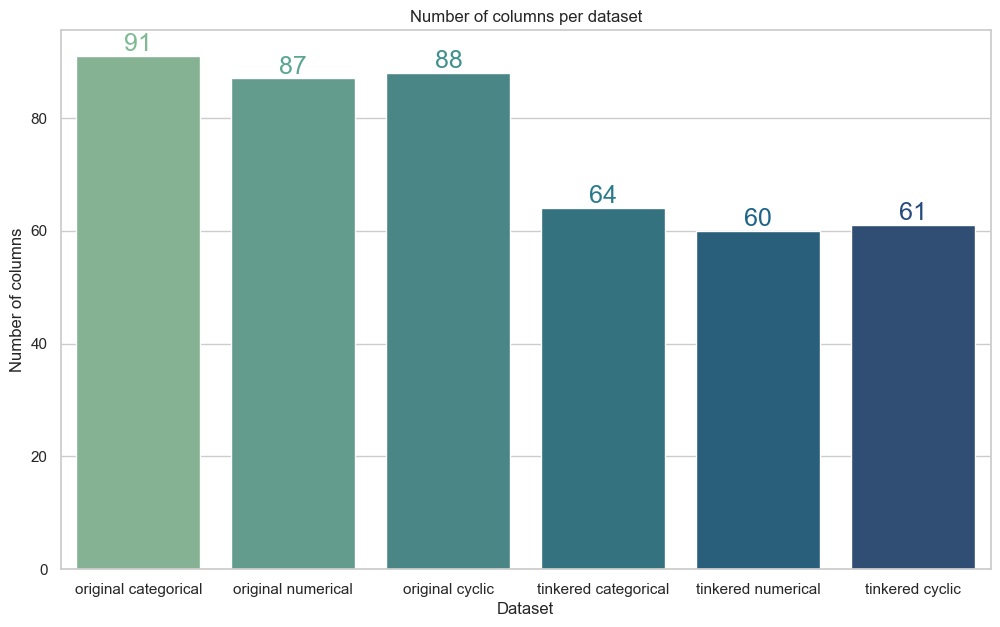

In [68]:
# variable names for the multiple datasets we will create
def get_names(original_or_tinkered, time_categorical_or_numerical_or_cyclic):

    names_common = ['has_children', 'income', 'direction_same','to_coupon',
    'destination_Home',
    'destination_No Urgent Place',
    'destination_Work',
    'passanger_Alone',
    'passanger_Friend(s)',
    'passanger_Kid(s)',
    'passanger_Partner','weather_Rainy',
    'weather_Snowy',
    'weather_Sunny','temperature_0',
    'temperature_1',
    'temperature_2',
    'gender_Female',
    'gender_Male',
    'maritalStatus_Divorced',
    'maritalStatus_Married partner',
    'maritalStatus_Single',
    'maritalStatus_Unmarried partner',
    'maritalStatus_Widowed',
    'education_0',
    'education_1',
    'education_3',
    'education_4',
    'education_5',
    'occupation_Architecture & Engineering',
    'occupation_Arts Design Entertainment Sports & Media',
    'occupation_Building & Grounds Cleaning & Maintenance',
    'occupation_Business & Financial',
    'occupation_Community & Social Services',
    'occupation_Computer & Mathematical',
    'occupation_Construction & Extraction',
    'occupation_Education&Training&Library',
    'occupation_Farming Fishing & Forestry',
    'occupation_Food Preparation & Serving Related',
    'occupation_Healthcare Practitioners & Technical',
    'occupation_Healthcare Support',
    'occupation_Installation Maintenance & Repair',
    'occupation_Legal',
    'occupation_Life Physical Social Science',
    'occupation_Management',
    'occupation_Office & Administrative Support',
    'occupation_Personal Care & Service',
    'occupation_Production Occupations',
    'occupation_Protective Service',
    'occupation_Retired',
    'occupation_Sales & Related',
    'occupation_Student',
    'occupation_Transportation & Material Moving',
    'occupation_Unemployed',
    'Y'

    ]

    names_original = ['age',
    'coupon_Bar',
    'coupon_Carry out & Take away',
    'coupon_Coffee House',
    'coupon_Restaurant(20-50)',
    'coupon_RestaurantLessThan20',
    'Bar_0.0',
    'Bar_1.0',
    'Bar_2.0',
    'Bar_3.0',
    'Bar_4.0',
    'CoffeeHouse_0.0',
    'CoffeeHouse_1.0',
    'CoffeeHouse_2.0',
    'CoffeeHouse_3.0',
    'CoffeeHouse_4.0',
    'CarryAway_0.0',
    'CarryAway_1.0',
    'CarryAway_2.0',
    'CarryAway_3.0',
    'CarryAway_4.0',
    'RestaurantLessThan20_0.0',
    'RestaurantLessThan20_1.0',
    'RestaurantLessThan20_2.0',
    'RestaurantLessThan20_3.0',
    'RestaurantLessThan20_4.0',
    'Restaurant20To50_0.0',
    'Restaurant20To50_1.0',
    'Restaurant20To50_2.0',
    'Restaurant20To50_3.0',
    'Restaurant20To50_4.0'
    ]

    names_tinkered = ['tax_age','coupon_importance','coupon_freq_total','expiration_binary',]

    names_time_categorical = [
    'time_10AM',
    'time_10PM',
    'time_2PM',
    'time_6PM',
    'time_7AM'
    ]

    names_time_numerical = ['time_values']

    names_time_cyclic = ['time_sin','time_cos']

    if original_or_tinkered == 'original':
        if time_categorical_or_numerical_or_cyclic == 'categorical':
            return names_common + names_original + names_time_categorical
        elif time_categorical_or_numerical_or_cyclic == 'numerical':
            return names_common + names_original + names_time_numerical
        elif time_categorical_or_numerical_or_cyclic == 'cyclic':
            return names_common + names_original + names_time_cyclic
        else:
            print('Invalid time_categorical_or_numerical_or_cyclic value.')
    elif original_or_tinkered == 'tinkered':
        if time_categorical_or_numerical_or_cyclic == 'categorical':
            return names_common + names_tinkered + names_time_categorical
        elif time_categorical_or_numerical_or_cyclic == 'numerical':
            return names_common + names_tinkered + names_time_numerical
        elif time_categorical_or_numerical_or_cyclic == 'cyclic':
            return names_common + names_tinkered + names_time_cyclic
        else:
            print('Invalid time_categorical_or_numerical_or_cyclic value.')
    else:
        print('Invalid original_or_tinkered value.')

#### datasets ####
# with original-ish features
df_original_categorical = df_ready[get_names('original','categorical')]
df_original_numerical = df_ready[get_names('original','numerical')]
df_original_cyclic = df_ready[get_names('original','cyclic')]

# with tinkered features (taxonomies, new variables, some were removed as well, etc)
df_tinkered_categorical = df_ready[get_names('tinkered','categorical')]
df_tinkered_numerical = df_ready[get_names('tinkered','numerical')]
df_tinkered_cyclic = df_ready[get_names('tinkered','cyclic')]

# how many columns do they have? let's plot it
sizes = [len(df_original_categorical.columns), len(df_original_numerical.columns), len(df_original_cyclic.columns), len(df_tinkered_categorical.columns), len(df_tinkered_numerical.columns), len(df_tinkered_cyclic.columns)]
labels = ['original categorical', 'original numerical', 'original cyclic', 'tinkered categorical', 'tinkered numerical', 'tinkered cyclic']
# with the actual values on top of the bars, but still with colors for each bar
plt.figure(figsize=(12, 7))
colors = sns.color_palette("crest", len(sizes))
ax = sns.barplot(x=labels, y=sizes, palette=colors)
plt.xlabel('Dataset')
plt.ylabel('Number of columns')
plt.title('Number of columns per dataset')
for i in range(len(sizes)):
    plt.text(i, sizes[i], sizes[i], ha='center', va='bottom', color = colors[i], fontsize=18)
plt.show()


In [70]:
# One class svm
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

# One-Class SVM
oc_svm = OneClassSVM(nu=0.05, kernel="rbf")
oc_svm_labels = oc_svm.fit_predict(df_ready)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.05)
iso_forest_labels = iso_forest.fit_predict(df_ready)

# Convert labels from (-1,1) to (0,1) for consistency
oc_svm_labels = (oc_svm_labels + 1) // 2
iso_forest_labels = (iso_forest_labels + 1) // 2

oc_svm_labels, iso_forest_labels

# count outliers for each model
oc_svm_outliers = sum(oc_svm_labels == 0)
iso_forest_outliers = sum(iso_forest_labels == 0)

oc_svm_outliers, iso_forest_outliers

(631, 631)

In [83]:
oc_svm_outliers == iso_forest_outliers

True

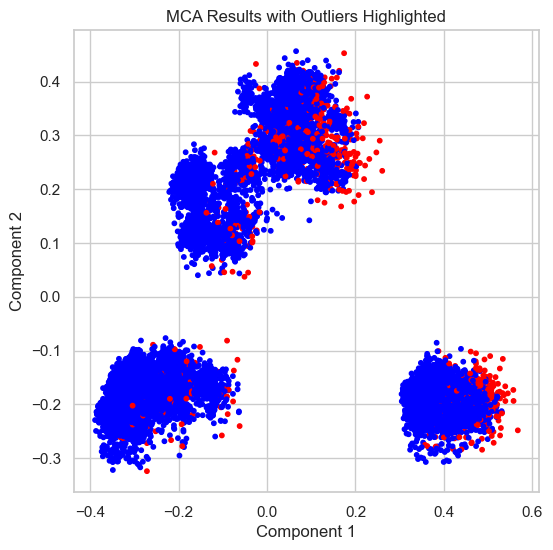

In [85]:
# Create a copy of the DataFrame excluding the 'Y' column
df_features = df_ready.drop('Y', axis=1)

# Add the outlier labels to this new DataFrame
df_features['outlier'] = iso_forest_labels

# Apply MCA
mca = prince.MCA()
mca_coords = mca.fit_transform(df_features)

# Plot using matplotlib
colors = ['red' if outlier == 0 else 'blue' for outlier in df_features['outlier']]
plt.figure(figsize=(6, 6))
plt.scatter(mca_coords[0], mca_coords[1], c=colors, s=10)
plt.title("MCA Results with Outliers Highlighted")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

In [84]:
df_ready['Y']

0        1
1        0
2        1
3        0
4        0
        ..
12679    1
12680    1
12681    0
12682    0
12683    0
Name: Y, Length: 12610, dtype: int64

# Feature Selection: Mutual Information

### Defining Mutual Information between two variables.

In [ ]:
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.metrics import mutual_info_score

def compute_mi(x, y):
    """Compute mutual information MI(x;y)"""
    contingency = np.histogram2d(x, y)[0]
    
    # Apply Laplace smoothing
    contingency += 1
    
    return chi2_contingency(contingency)[1]


In [ ]:
# testing on the dataset

# MI(age, age)

print('MI(age, age) =', compute_mi(df_ready['age'], df_ready['age']))

# MI(age, Y)

print('MI(age, Y) =', compute_mi(df_ready['age'], df_ready['Y']))

### JMIM

In [ ]:
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.metrics import mutual_info_score

def compute_mi(x, y):
    """Compute mutual information MI(x;y)"""
    contingency = np.histogram2d(x, y)[0]
    
    # Apply Laplace smoothing
    contingency += 1
    
    return chi2_contingency(contingency)[1]

def compute_cmi(x, y, z):
    """Compute conditional mutual information MI(x;y|z)"""
    mi_xz = compute_mi(x, z)
    mi_yz = compute_mi(y, z)
    mi_xyz = compute_mi(x, y + z * 2)  # Combining y and z into a single 2-bit number
    
    return mi_xz + mi_yz - mi_xyz

def JMIM(data, target, n_features):
    """
    JMIM feature selection.
    data: DataFrame with numerical features.
    target: binary target variable.
    n_features: number of features to select.
    """
    S = []
    while len(S) < n_features:
        max_j_value = -np.inf
        selected_feature = None
        
        for feature in data.columns:
            if feature not in S:
                mi = compute_mi(data[feature], target)
                
                if S:
                    max_cmi = max(compute_cmi(data[feature], target, data[s]) - compute_mi(data[feature], data[s]) - compute_mi(data[s], target) for s in S)
                    j_value = mi - max_cmi
                else:
                    j_value = mi
                
                if j_value > max_j_value:
                    max_j_value = j_value
                    selected_feature = feature
        
        if selected_feature:
            S.append(selected_feature)
    
    return S

### Applying the Feature Selection

In [ ]:
# applying JMIM feature selection

df_for_FS = df_tinkered_numerical.copy()

selected_features = JMIM(df_for_FS.drop(columns=['Y']), df_for_FS['Y'], 10)
print("Selected features:", selected_features)

# Selected features: ['income', 'time_6PM', 'coupon_freq_total', 'coupon_importance', 'age', 'has_children', 'direction_same', 'to_coupon', 'tax_age', 'time_values']

# Classification with variance/bias tradeoff methods

In [ ]:
# dataset that will be used for classification
df_classification = df_ready[selected_features + ['Y']]

df_classification = df_tinkered_numerical.copy()

#df_classification.columns

In [ ]:
df_classification.columns

In [ ]:
X = df_classification.drop("Y", axis=1)
y = df_classification["Y"]

### Preprocessing and model identification

In [ ]:
# preprocessing function
def preprocess_general(X_train, X_test, y_train):
    return X_train, X_test

# Define model configurations
model_configs = [
    {
        'name': 'KNN',
        'preprocess': preprocess_general,
        'classifier': KNeighborsClassifier(n_neighbors=11, weights='uniform', p=2)
    },
    {
        'name': 'Naive Bayes',
        'preprocess': preprocess_general,
        'classifier': GaussianNB()
    },
    {
        'name': 'Random Forest',
        'preprocess': preprocess_general,
        'classifier': RandomForestClassifier(n_estimators=500, max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, random_state=42)
    },
    {
        'name': 'XGBoost',
        'preprocess': preprocess_general,
        'classifier': XGBClassifier(
            n_estimators=1000,
            max_depth=15,
            learning_rate=0.01,
            subsample=0.5,
            colsample_bytree=0.5,
            gamma=0.1,
            random_state=42
        )
    },
    {
        'name': 'Logistic Regression',
        'preprocess': preprocess_general,
        'classifier': LogisticRegression(max_iter=1000, C=0.1, penalty='l1', solver='liblinear')
    }
]

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Holdout

In [ ]:
# Define a function to split data with multiple test sizes
def split_data_for_multiple_test_sizes(X, y, test_sizes):
    data_splits = []
    for test_size in test_sizes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        data_splits.append((X_train, X_test, y_train, y_test))
    return data_splits

test_sizes = [0.2, 0.25, 0.3]  # This corresponds to 80%, 75%, and 70% training sizes
data_splits = split_data_for_multiple_test_sizes(X, y, test_sizes)

# Loop through the splits
for data in data_splits:
    X_train, X_test, y_train, y_test = data
    print(f"\nTraining Size: {len(X_train)}, Test Size: {len(X_test)}\n{'-'*40}")
    
    # Updated loop for models to include categorical columns
    for model_config in model_configs:
        print(f"Running {model_config['name']}...")
        
        X_train_processed, X_test_processed = model_config['preprocess'](X_train, X_test, y_train)

        X_train_processed = np.ascontiguousarray(X_train_processed)
        X_test_processed = np.ascontiguousarray(X_test_processed)

        model_config['classifier'].fit(X_train_processed, y_train)
    
        y_pred = model_config['classifier'].predict(X_test_processed)

        # ROC curve and AUC
        if len(set(y_test)) == 2:  # Ensure binary classification
            y_prob = model_config['classifier'].predict_proba(X_test_processed)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {model_config["name"]}')
            plt.legend(loc="lower right")
            plt.show()

        # F1 score
        f1 = f1_score(y_test, y_pred)
        print(f"{model_config['name']} F1 Score: {f1:.4f}")

        # Compute the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot the confusion matrix using ConfusionMatrixDisplay
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(y_test))
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_config["name"]}')
        plt.show()
        
        print(f"{model_config['name']} Classification Report:")
        print(classification_report(y_test, y_pred))
        print('-' * 60)

### K Cross-validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Number of splits
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate over each model
for model_config in model_configs:
    
    accuracies = []
    print(f"Running {model_config['name']}...")
    
    # Cross-validation loop
    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        X_train_processed, X_val_processed = model_config['preprocess'](X_train_fold, X_val_fold, y_train_fold)

        X_train_processed = np.ascontiguousarray(X_train_processed)
        X_val_processed = np.ascontiguousarray(X_val_processed)

        model_config['classifier'].fit(X_train_processed, y_train_fold)
    
        y_pred_val = model_config['classifier'].predict(X_val_processed)
        # ROC curve and AUC
        if len(set(y_val_fold)) == 2:  # Ensure binary classification
            y_prob_val = model_config['classifier'].predict_proba(X_val_processed)[:, 1]
            fpr, tpr, _ = roc_curve(y_val_fold, y_prob_val)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {model_config["name"]}')
            plt.legend(loc="lower right")
            plt.show()

        # F1 score
        f1 = f1_score(y_val_fold, y_pred_val)
        print(f"{model_config['name']} F1 Score for current fold: {f1:.4f}")

        # Confusion matrix
        cm = confusion_matrix(y_val_fold, y_pred_val)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(y_val_fold))
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_config["name"]}')
        plt.show()

        # Accuracy for the fold
        fold_accuracy = accuracy_score(y_val_fold, y_pred_val)
        accuracies.append(fold_accuracy)
    
    avg_accuracy = sum(accuracies) / n_splits
    print(f"{model_config['name']} Average Accuracy over {n_splits} folds: {avg_accuracy:.4f}")
    print('-' * 60)

### Bootstrapping

In [ ]:
from sklearn.utils import resample

def bootstrap_evaluation(models, X, y, n_iterations=1000, sample_size=None):
    """
    Perform bootstrap evaluation for given models on data X, y.
    
    models: list of dictionaries, where each dictionary has 'name', 'preprocess', and 'classifier'
    X: Feature matrix
    y: Target vector
    n_iterations: Number of bootstrap iterations
    sample_size: Size of each bootstrap sample, if None, set to len(y)
    
    Returns: model scores for each iteration
    """
    if sample_size is None:
        sample_size = len(y)

    # Store scores for each model and iteration
    model_scores = {model['name']: [] for model in models}

    for i in range(n_iterations):
        print(f"Iteration {i+1}/{n_iterations}")
        # Sample data with replacement
        X_sample, y_sample = resample(X, y, n_samples=sample_size, replace=True)

        # Split into train and test sets (e.g., 80/20 split)
        X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=i)

        # Process, train, and evaluate each model
        for config in models:
            print(f"Running {config['name']}...")
            
            X_train_pp, X_test_pp = config['preprocess'](X_train, X_test, y_train)

            X_train_pp = np.ascontiguousarray(X_train_pp)
            X_test_pp = np.ascontiguousarray(X_test_pp)

            
            clf = config['classifier']
            clf.fit(X_train_pp, y_train)
            y_pred = clf.predict(X_test_pp)
    
            # ROC curve and AUC
            if len(set(y_test)) == 2:  # Ensure binary classification
                y_prob = clf.predict_proba(X_test_pp)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_prob)
                roc_auc = auc(fpr, tpr)

                plt.figure()
                plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve for {config["name"]} on Iteration {i+1}')
                plt.legend(loc="lower right")
                plt.show()

            # F1 score
            f1 = f1_score(y_test, y_pred)
            print(f"{config['name']} F1 Score for Iteration {i+1}: {f1:.4f}")

            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(y_test))
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f'Confusion Matrix for {config["name"]} on Iteration {i+1}')
            plt.show()

            # Accuracy for the iteration
            score = accuracy_score(y_test, y_pred)
            model_scores[config['name']].append(score)

    return model_scores

# Use the same `model_configs` list from the previous K-fold CV example
bootstrap_scores = bootstrap_evaluation(model_configs, X, y, n_iterations=10)
# Maybe we need do run this for 50-100 times for stability

### Boostrapping results

In [ ]:
# Plot the scores, as distributions (not with distplot, it is deprecated), with the legend on the top left corner
plt.figure(figsize=(12, 7))
for model_name, scores in bootstrap_scores.items():
    sns.kdeplot(scores, label=model_name, fill=True)
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.title('Accuracy Distributions for Each Model')
plt.legend(loc='upper left', bbox_to_anchor=(.0, 1))
plt.show()